# Load Packages

In [ ]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
import missingno as msno

#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import clone

#algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,  f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer, mean_squared_error
from imblearn.over_sampling import SMOTE


# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
import shap

random_state = 57
np.random.seed(57)
random.seed(57)


# Look at Data

In [ ]:
# 1. Load the Data
original_train_df = pd.read_csv("data.csv")

# Copy the Dataset 
pipe_data = original_train_df.copy()

# Dataset used for analysis
train_df = original_train_df.copy()
train_df.head()

,Sex,Age,Previous experience,Hearing Problems,Education Level,BMI,Care level,QMCI Points,4 m Gehtest,Stand-up-Test,...,Verbal Support Cloudy,Verbal Support Lumina,Verbal Support Hexagon,Verbal Support Evolve,Verbal Support Flexi,Verbal Support Drops,Verbal Support Simon,Verbal Support React,Verbal Support Arrows,Verbal Support Flaneur
0,w,89.0,No,Yes,9.0,18.0,6.0,13.5,"6,21 - 8,7 s","≥ 16,7 s",...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3
1,w,84.0,No,No,10.0,23.1,5.0,43.5,"6,21 - 8,7 s","> 60 s, oder Aufgabe nicht bewältigt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,w,92.0,No,Yes,11.0,25.4,2.0,9.0,"6,21 - 8,7 s","13,70 - 16,69 s",...,1.0,1.0,3.0,NaN,NaN,3.0,3.0,NaN,3.0,1
3,w,89.0,No,No,16.0,28.4,2.0,52.0,"4, 82 - 6,20 s","11,2 - 13,69 s",...,NaN,NaN,3.0,1.0,1.0,3.0,3.0,1.0,2.0,1
4,m,95.0,No,No,9.0,24.2,7.0,56.5,"> 8,7 s","> 60 s, oder Aufgabe nicht bewältigt",...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           101 non-null    object 
 1   Age                           100 non-null    float64
 2   Previous experience           101 non-null    object 
 3   Hearing Problems              101 non-null    object 
 4   Education Level               75 non-null     float64
 5   BMI                           62 non-null     float64
 6   Care level                    86 non-null     float64
 7   QMCI Points                   100 non-null    float64
 8   4 m Gehtest                   101 non-null    object 
 9   Stand-up-Test                 101 non-null    object 
 10  SPPB Points                   101 non-null    float64
 11  Rocket                        101 non-null    object 
 12  Simple                        100 non-null    object 
 13  Divid

In [4]:
train_df[['Sex', 'Age', 'Previous experience', 'Education Level', 'BMI',
    'Care level', 'QMCI Points', 'SPPB Points',
     "Mobility Aids"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100.0,86.590000,6.843260,65.00,82.000,88.00,92.0000,99.0
Education Level,75.0,10.253333,2.325495,6.00,9.000,9.00,11.0000,16.0
BMI,62.0,25.338710,5.490361,14.76,21.425,24.50,28.3925,40.3
Care level,86.0,4.697674,2.544058,0.00,3.000,5.00,6.0000,10.0
QMCI Points,100.0,38.465000,17.823809,5.00,24.875,38.75,52.1250,77.5
SPPB Points,101.0,5.534653,2.504254,0.00,4.000,5.00,7.0000,11.0


# Prepare Dataset
- Sorting of the columns into features and game columns
- Ordinal Encoding 
- Greate new Feature Game (1 Dataentry per Game per Participant)

In [ ]:
# List of games
games = ['Rocket', 'Simple', 'Divided', 'Birds', 'Habitats', 'Snake', 'Targets', 'Sams Garden',
         'Ladybug', 'Ski', 'Cloudy', 'Lumina', 'Hexagon', 'Evolve', 'Flexi', 'Drops', 'Simon',
         'React', 'Arrows', 'Flaneur']

# List of Features
participant_cols = [
    'Sex','Age', 'Previous experience', 'Education Level', 'BMI',
    'Care level', 'QMCI Points', '4 m Gehtest', 'Stand-up-Test',
     "Mobility Aids", "Balance-Test"

]

#Ordinal Encoding
mapping_mobility = {"Nothing": 0, "Cane": 1, "Walker with Wheels": 1,
                    "Walking Frame": 1, "Wheelchair": 1}
mapping_walking = {"Gehstrecke nicht bewältigt": 0, "> 8,7 s": 1,"6,21 - 8,7 s": 2, "4, 82 - 6,20 s": 3 ,"< 4,82 s": 4}
mapping_standing = {'> 60 s, oder Aufgabe nicht bewältigt': 0, '≥ 16,7 s': 1, '13,70 - 16,69 s': 2, '11,2 - 13,69 s': 3, '≤ 11,19 s': 4}
for m in (mapping_mobility, mapping_walking, mapping_standing):
    train_df.replace(m, inplace=True)


# Assign a Participant_ID if not already present
train_df['Participant_ID'] = train_df.index

# Create long-form data 
rows = []
for idx, row in train_df.iterrows():
    for game in games:
        rows.append({
            'Participant_ID': idx,
            'Game': game,
            'Gameplay': row.get(game),
            'Physical Support': row.get(f'Physical Support {game}', None),
            'Verbal Support': row.get(f'Verbal Support {game}', None),
            **{col: row[col] for col in participant_cols}
        })

# Convert to DataFrame
train_df = pd.DataFrame(rows)

In [6]:
train_df.head(5)

,Participant_ID,Game,Gameplay,Physical Support,Verbal Support,Sex,Age,Previous experience,Education Level,BMI,Care level,QMCI Points,4 m Gehtest,Stand-up-Test,Mobility Aids,Balance-Test
0,0,Rocket,Yes,1.0,2.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
1,0,Simple,Yes,1.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
2,0,Divided,No,3.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
3,0,Birds,Yes,1.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0
4,0,Habitats,No,3.0,3.0,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0


In [7]:
train_df.shape

(2020, 16)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Participant_ID       2020 non-null   int64  
 1   Game                 2020 non-null   object 
 2   Gameplay             1613 non-null   object 
 3   Physical Support     1613 non-null   float64
 4   Verbal Support       1613 non-null   float64
 5   Sex                  2020 non-null   object 
 6   Age                  2000 non-null   float64
 7   Previous experience  2020 non-null   object 
 8   Education Level      1500 non-null   float64
 9   BMI                  1240 non-null   float64
 10  Care level           1720 non-null   float64
 11  QMCI Points          2000 non-null   float64
 12  4 m Gehtest          2020 non-null   int64  
 13  Stand-up-Test        2020 non-null   int64  
 14  Mobility Aids        2020 non-null   int64  
 15  Balance-Test         2020 non-null   f

In [9]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
BMI,780,38.613861
Education Level,520,25.742574
Gameplay,407,20.148515
Physical Support,407,20.148515
Verbal Support,407,20.148515
Care level,300,14.851485
Age,20,0.990099
QMCI Points,20,0.990099


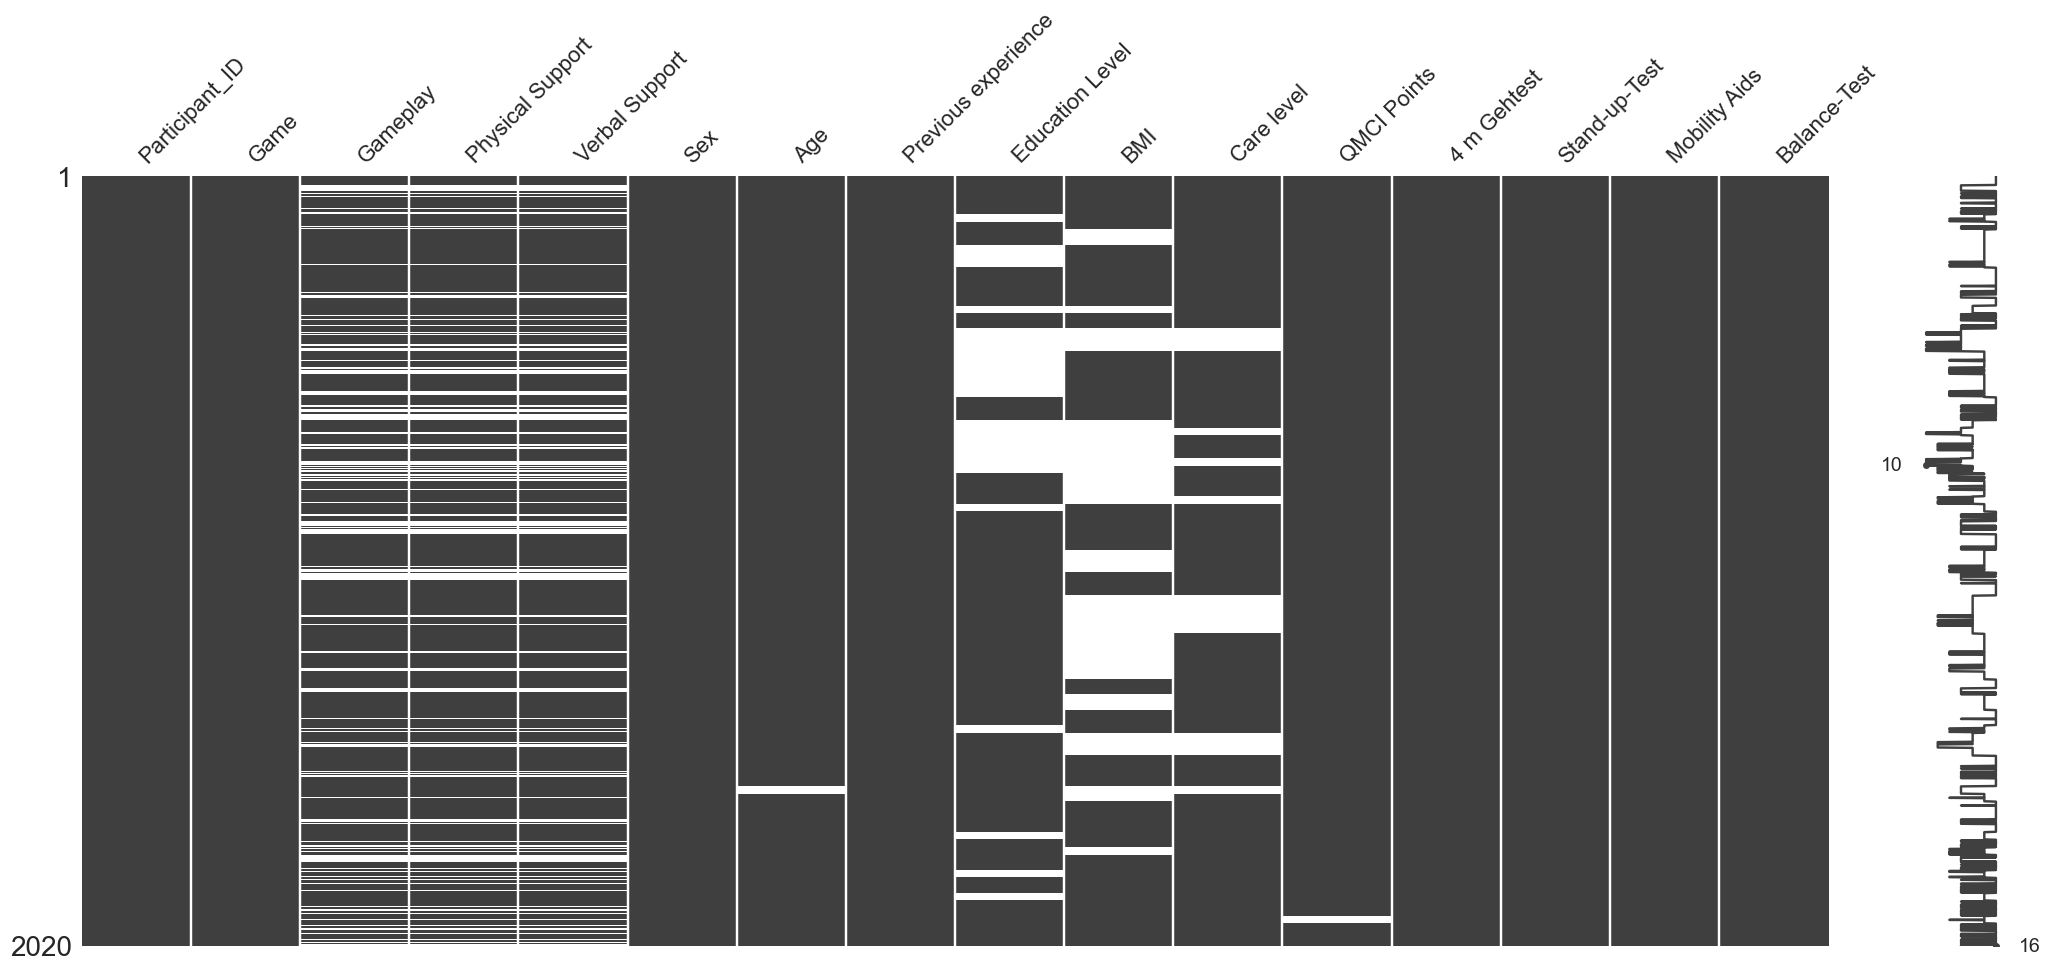

In [ ]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

In [11]:
#There is no point having missings on target
train_df = train_df.dropna(subset=["Gameplay"])

This drops all Rows with missing target

In [12]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,count,percent
BMI,648,40.173590
Education Level,425,26.348419
Care level,243,15.065096
Age,20,1.239926
QMCI Points,19,1.177929


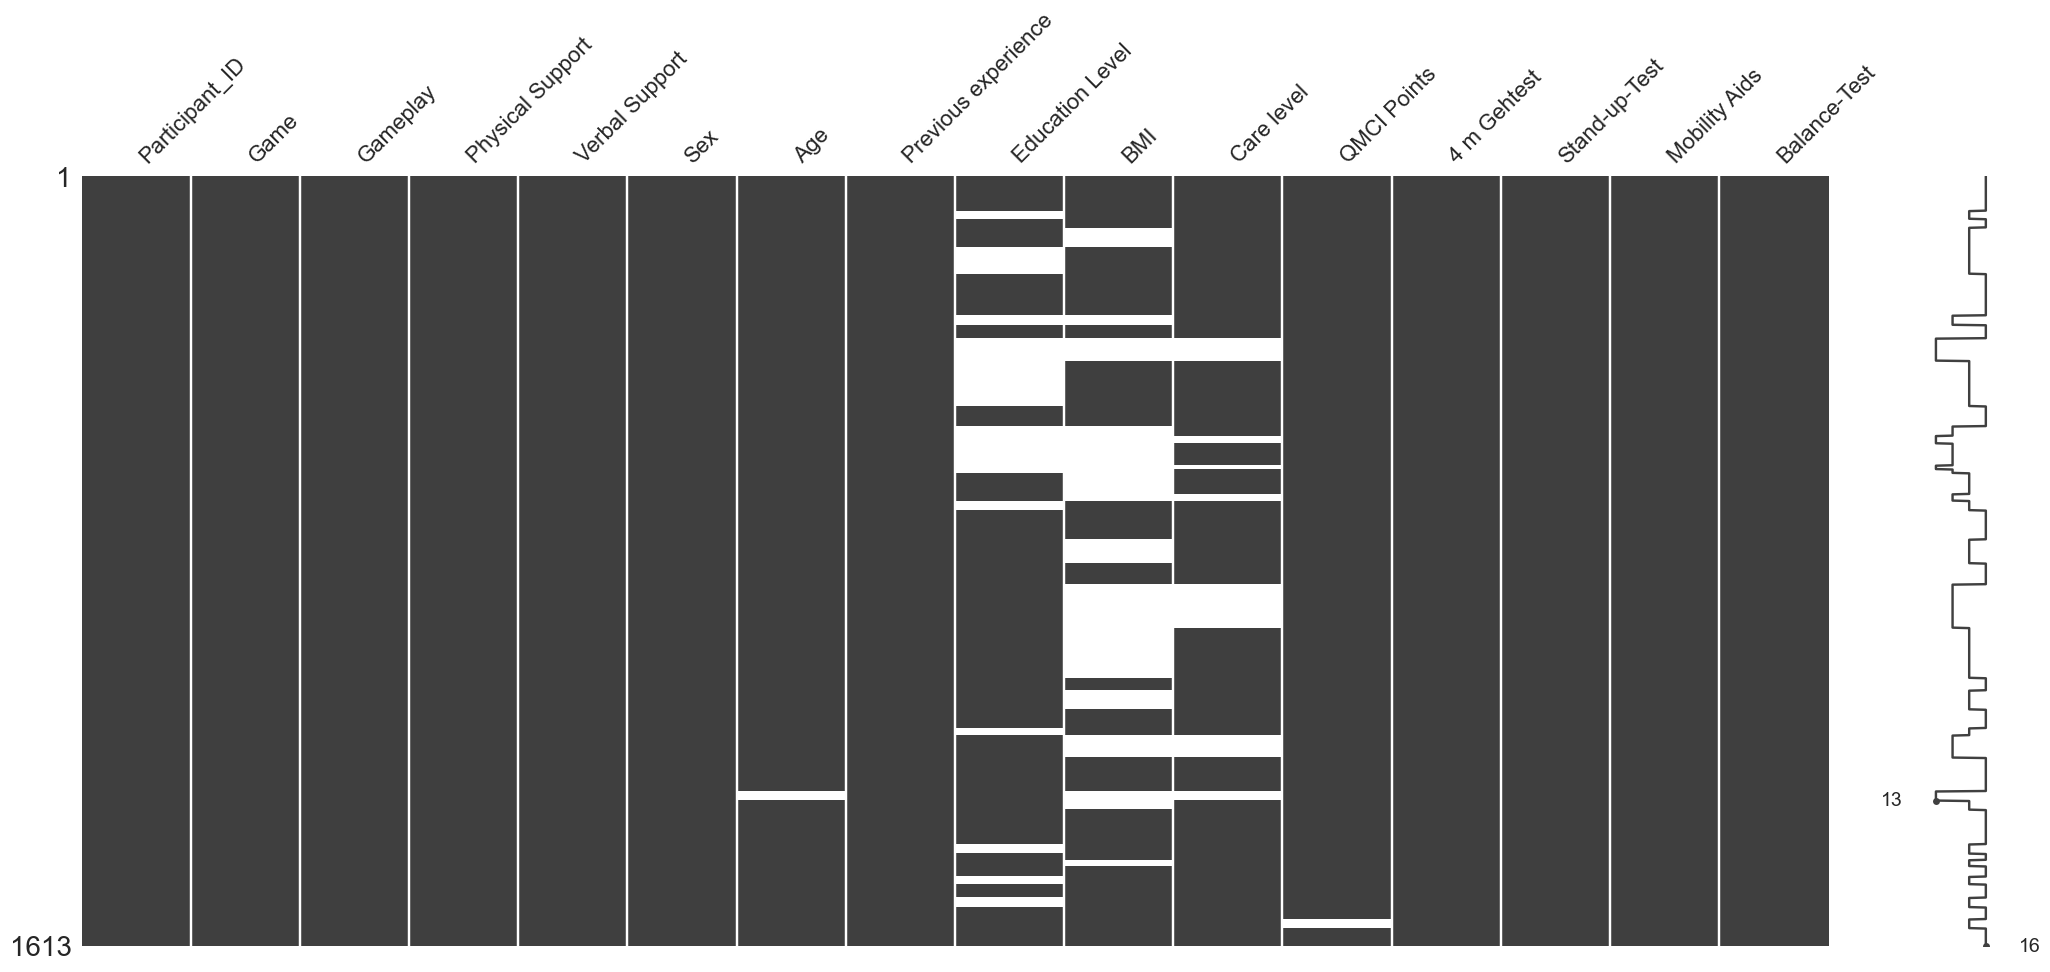

In [13]:
msno.matrix(train_df)
plt.show()

## Create Outcome variables

In [14]:
target_game = "Gameplay"
train_df[target_game] = train_df[target_game].map({'Yes': 1, 'No': 0})

# Define dynamic feature column names
physical_col = "Physical Support"
verbal_col = "Verbal Support"
game_col = target_game  # this is the original target column in your dataset


# Create the combined class code column
train_df["Combined_Class_Code"] = (
    (train_df[physical_col] > 0).astype(int).astype(str) +
    (train_df[verbal_col] > 0).astype(int).astype(str) +
    train_df[game_col].astype(int).astype(str)
)

# Drop the individual columns
train_df.drop(columns=[physical_col, verbal_col, game_col], inplace=True)

In [15]:
train_df

,Participant_ID,Game,Sex,Age,Previous experience,Education Level,BMI,Care level,QMCI Points,4 m Gehtest,Stand-up-Test,Mobility Aids,Balance-Test,Combined_Class_Code
0,0,Rocket,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
1,0,Simple,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
2,0,Divided,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
3,0,Birds,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
4,0,Habitats,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,100,Hexagon,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
2013,100,Evolve,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
2014,100,Flexi,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,011
2015,100,Drops,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110


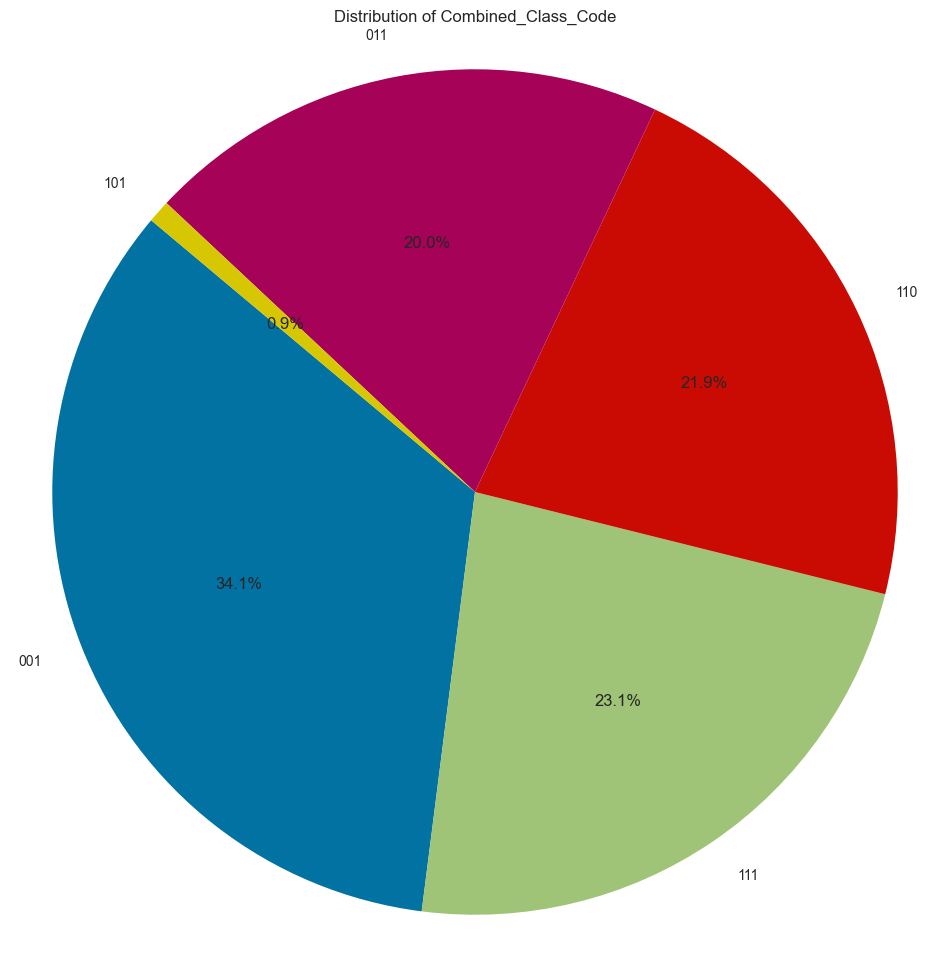

In [16]:
# Count occurrences of each unique code
counts = train_df["Combined_Class_Code"].value_counts()

# Plot pie chart
plt.figure(figsize=(12, 12))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Combined_Class_Code")
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()

In the pie chart above you can see the Outcome Variables: 
The first digit indicates whether the participant requires physical support (1 = yes, 0 = no), and the same applies to the second digit for verbal support. 
The third digit reflects the participant’s gameplay ability (1 = yes, 0 = no). 

110 – Not able to play
111 – Needs verbal + physical support
101 – Needs physical support only
011 – Needs verbal support only
001 – Independent play



Due to the observed under-representation, the combination 101 has been excluded, resulting in the four outcome labels (110, 111, 011, 001). 

In [17]:
train_df["Combined_Class_Code"].value_counts()

Combined_Class_Code
001    550
111    373
110    353
011    323
101     14
Name: count, dtype: int64

In [ ]:
# Remove 
train_df = train_df[train_df['Combined_Class_Code'] != "101"]
train_df["Combined_Class_Code"].value_counts()

Combined_Class_Code
001    550
111    373
110    353
011    323
Name: count, dtype: int64

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1599 entries, 0 to 2019
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Participant_ID       1599 non-null   int64  
 1   Game                 1599 non-null   object 
 2   Sex                  1599 non-null   object 
 3   Age                  1579 non-null   float64
 4   Previous experience  1599 non-null   object 
 5   Education Level      1181 non-null   float64
 6   BMI                  956 non-null    float64
 7   Care level           1360 non-null   float64
 8   QMCI Points          1581 non-null   float64
 9   4 m Gehtest          1599 non-null   int64  
 10  Stand-up-Test        1599 non-null   int64  
 11  Mobility Aids        1599 non-null   int64  
 12  Balance-Test         1599 non-null   float64
 13  Combined_Class_Code  1599 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 187.4+ KB


In [20]:
# Convert object columns to category
for col in train_df.select_dtypes(include='object').columns:
    train_df[col] = train_df[col].astype('category')

In [21]:
train_df.nunique().sort_values()

Sex                      2
Previous experience      2
Mobility Aids            2
Combined_Class_Code      4
4 m Gehtest              5
Stand-up-Test            5
Balance-Test             5
Education Level          9
Care level              11
Game                    20
Age                     26
BMI                     55
QMCI Points             75
Participant_ID         101
dtype: int64

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1599 entries, 0 to 2019
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Participant_ID       1599 non-null   int64   
 1   Game                 1599 non-null   category
 2   Sex                  1599 non-null   category
 3   Age                  1579 non-null   float64 
 4   Previous experience  1599 non-null   category
 5   Education Level      1181 non-null   float64 
 6   BMI                  956 non-null    float64 
 7   Care level           1360 non-null   float64 
 8   QMCI Points          1581 non-null   float64 
 9   4 m Gehtest          1599 non-null   int64   
 10  Stand-up-Test        1599 non-null   int64   
 11  Mobility Aids        1599 non-null   int64   
 12  Balance-Test         1599 non-null   float64 
 13  Combined_Class_Code  1599 non-null   category
dtypes: category(4), float64(6), int64(4)
memory usage: 144.8 KB


In [23]:
# Store continuous and discrete features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Combined_Class_Code" ] # all columns without target

#category type features
categorical_features = [ "Game","Sex", "Hearing Problems", "Previous experience", "Mobility Aids"]

#float type features
continuous_features = list(set(feature_list) - set(categorical_features))

#sanity check
assert feature_list.sort() == (categorical_features + continuous_features).sort()


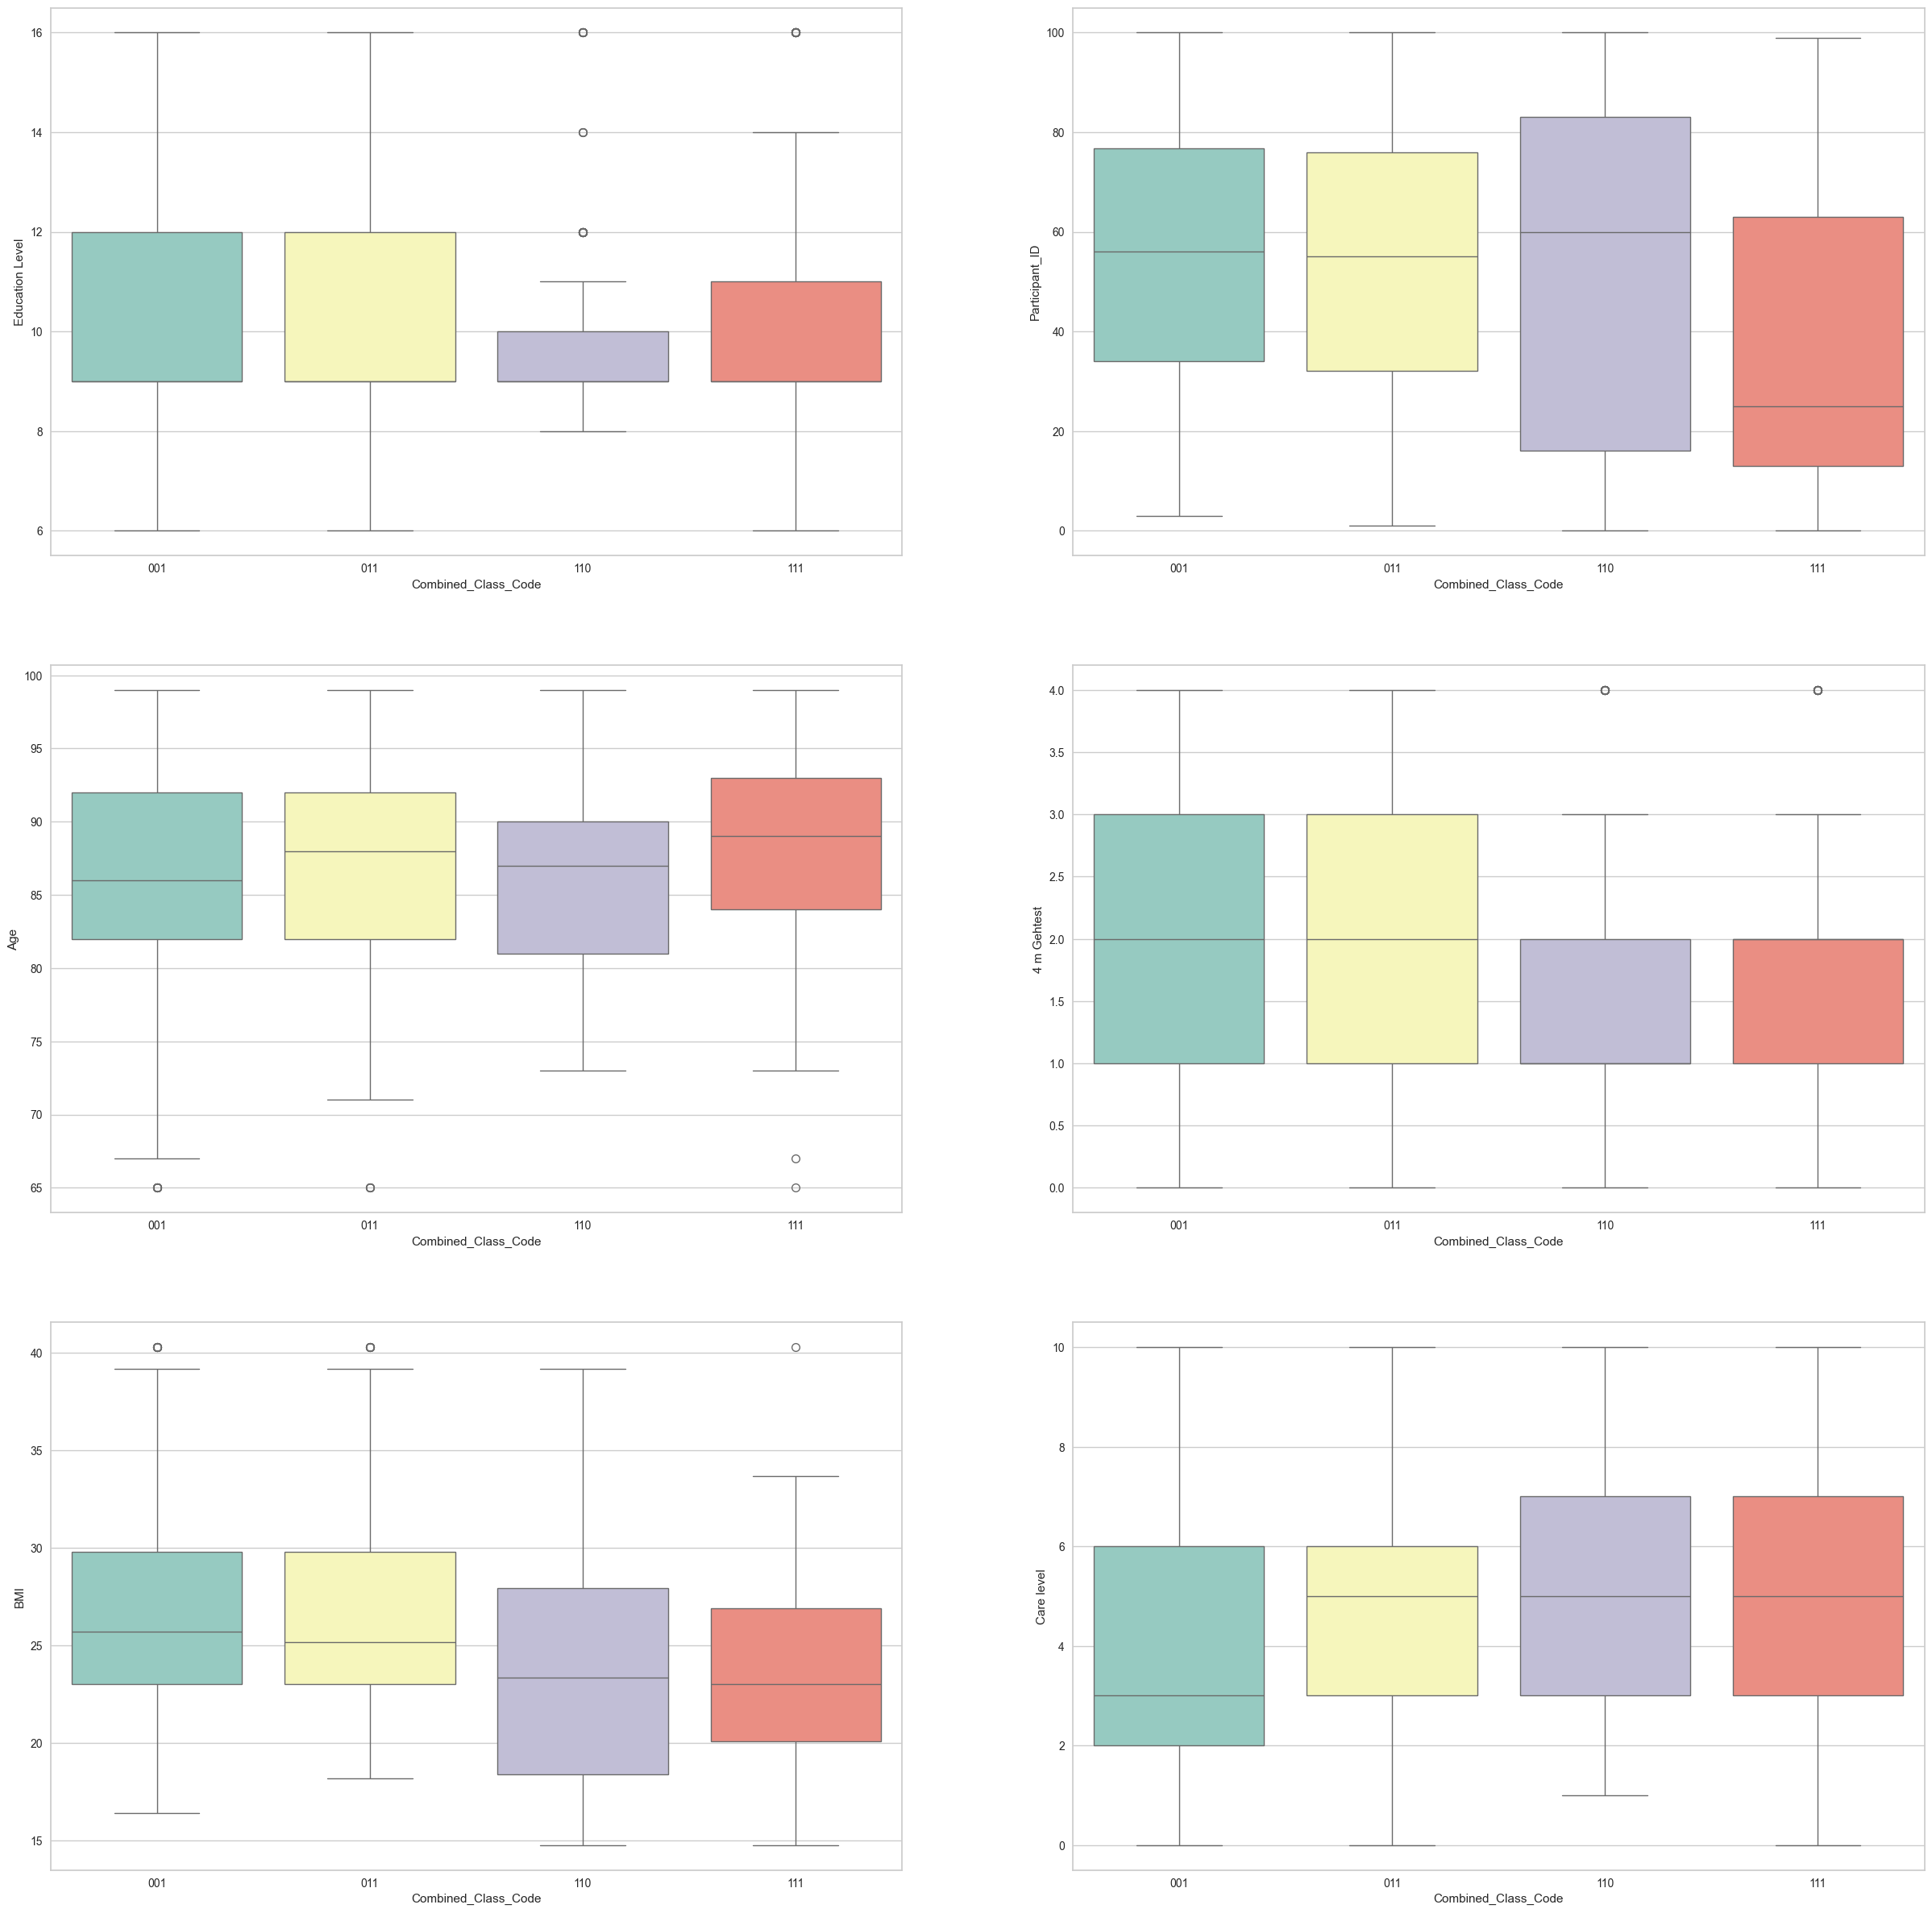

In [24]:
#Box-plots
fig, ax = plt.subplots(3, 2, figsize=(30, 30))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x="Combined_Class_Code", y=var, data=train_df, ax=subplot, palette='Set3')

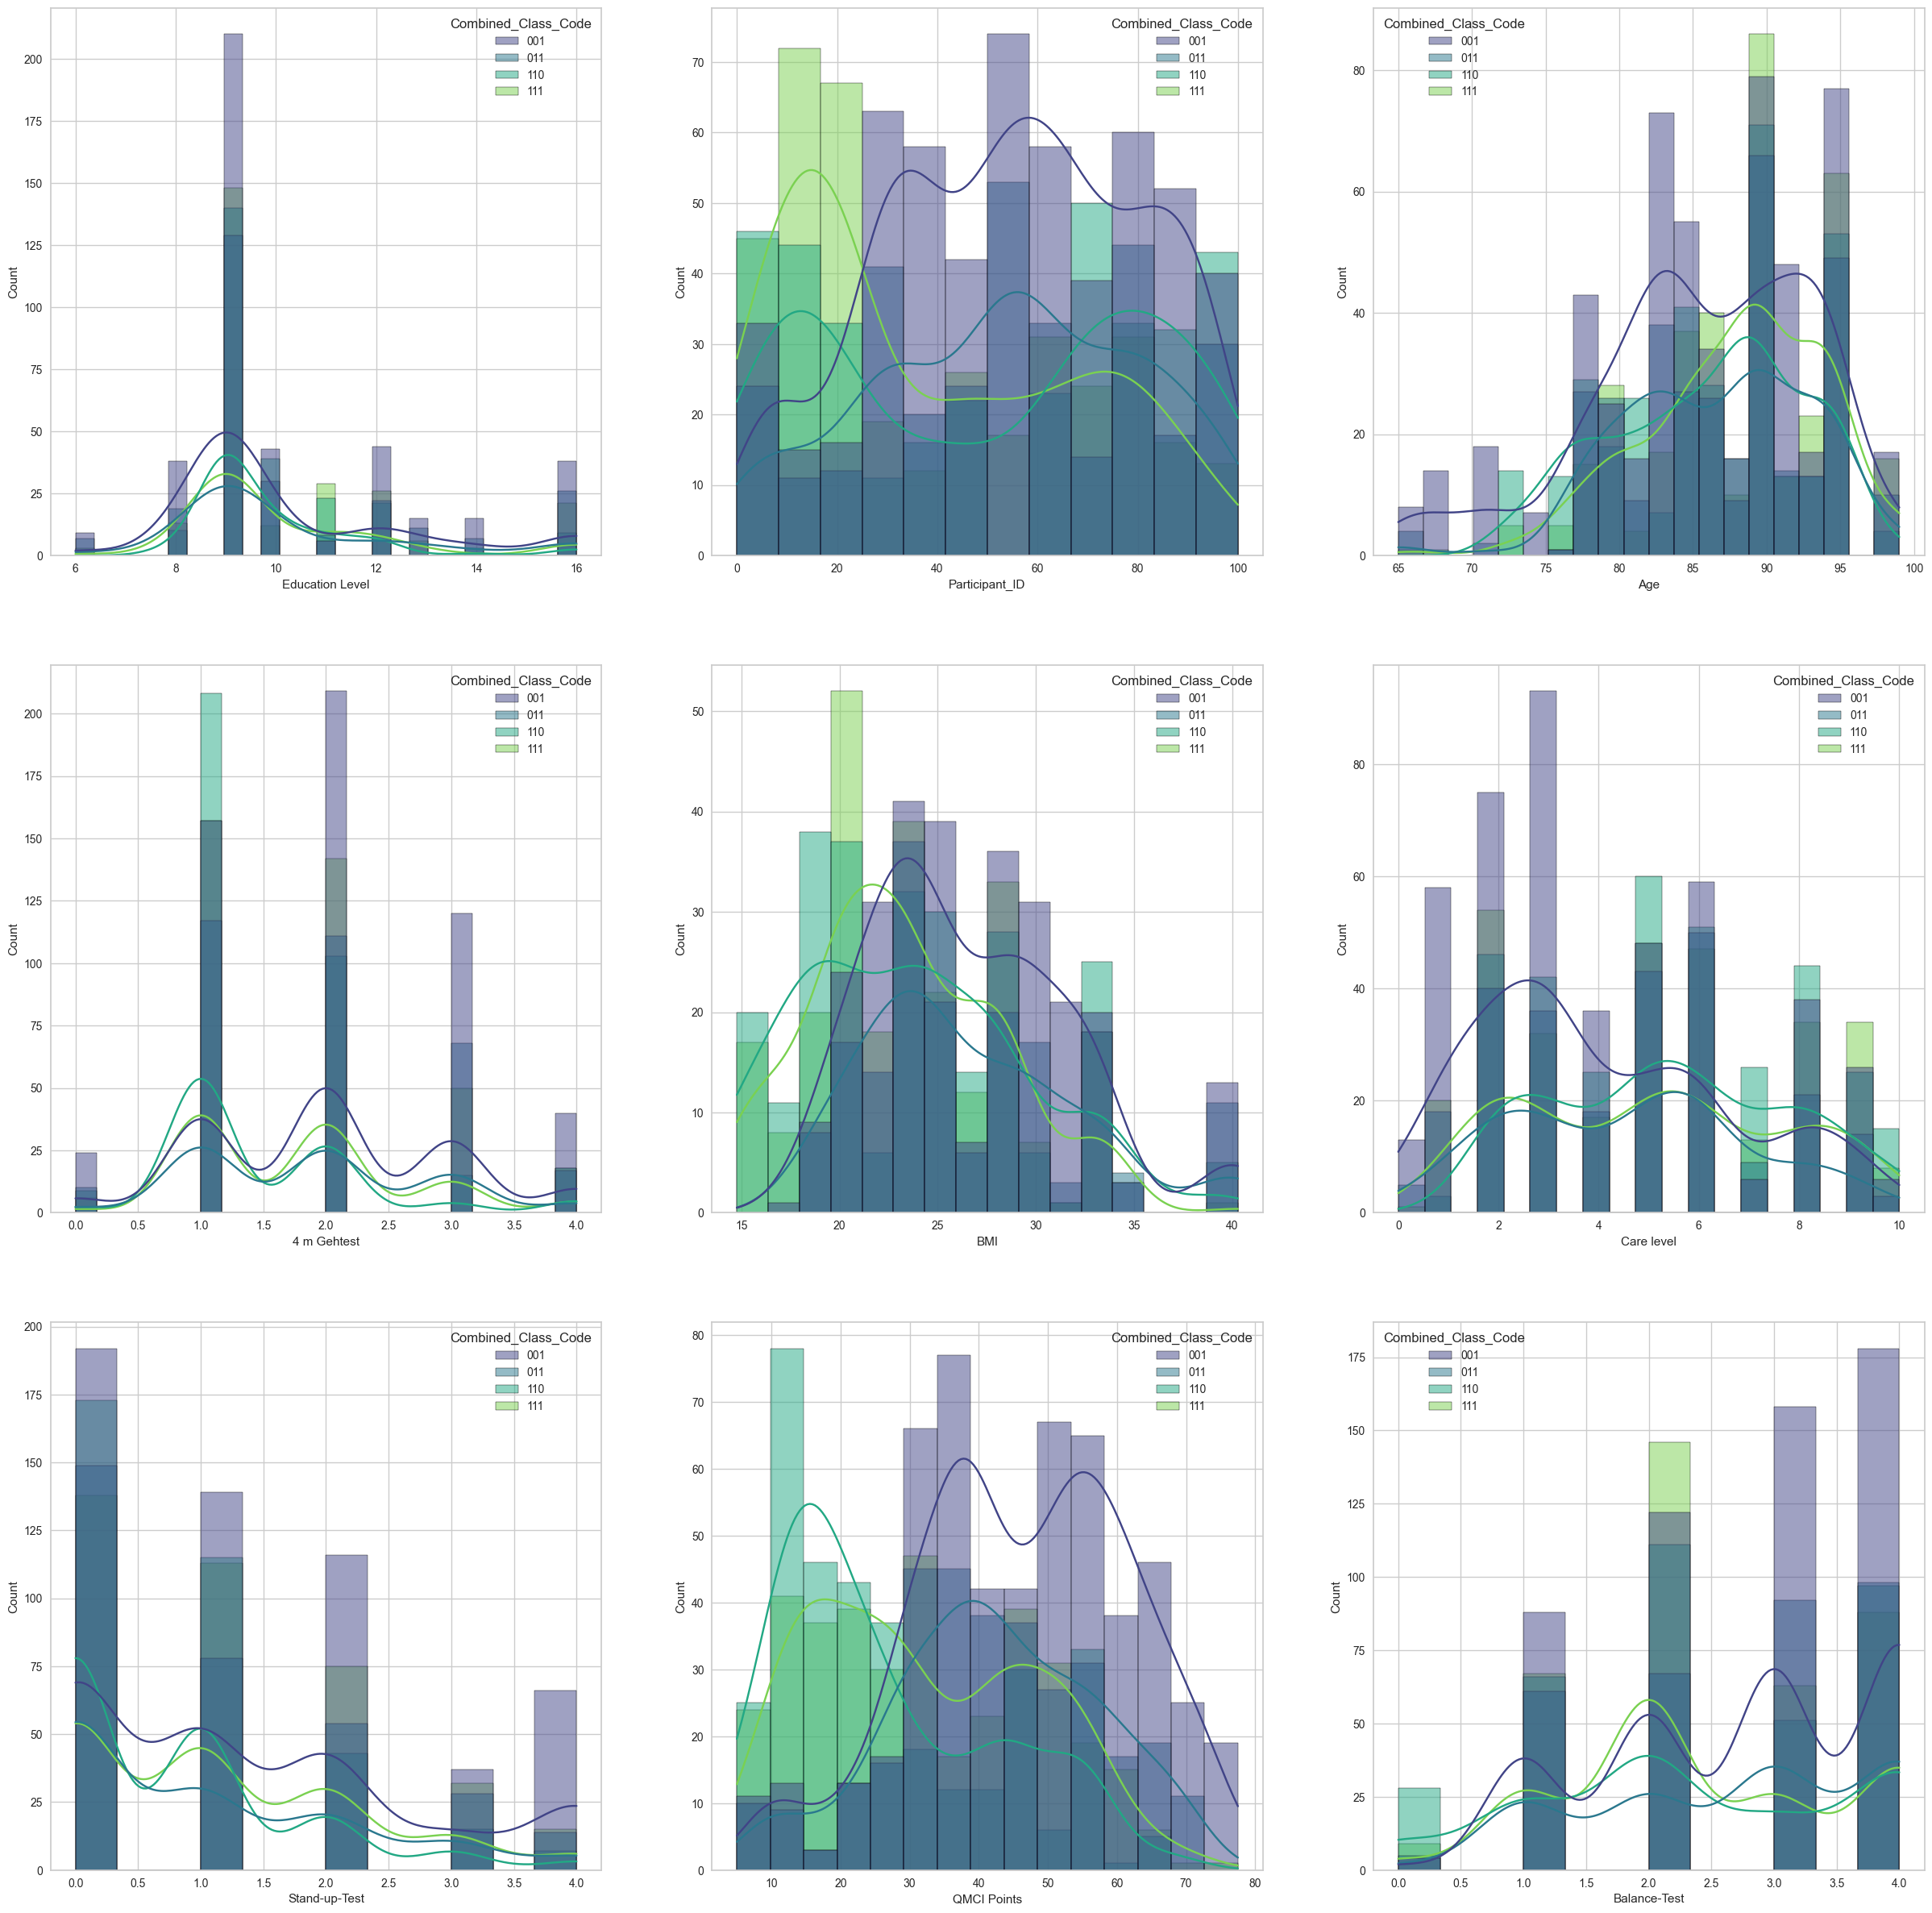

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(30, 30))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.histplot(x=var,  data=train_df, ax=subplot, hue="Combined_Class_Code", kde=True ,  palette='viridis')

In [26]:
train_df

,Participant_ID,Game,Sex,Age,Previous experience,Education Level,BMI,Care level,QMCI Points,4 m Gehtest,Stand-up-Test,Mobility Aids,Balance-Test,Combined_Class_Code
0,0,Rocket,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
1,0,Simple,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
2,0,Divided,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
3,0,Birds,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
4,0,Habitats,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,100,Hexagon,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
2013,100,Evolve,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110
2014,100,Flexi,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,011
2015,100,Drops,w,92.0,No,9.0,19.6,5.0,36.0,1,0,1,2.0,110


In [27]:
y = train_df["Combined_Class_Code"]

In [28]:
train_df[continuous_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1599 entries, 0 to 2019
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Education Level  1181 non-null   float64
 1   Participant_ID   1599 non-null   int64  
 2   Age              1579 non-null   float64
 3   4 m Gehtest      1599 non-null   int64  
 4   BMI              956 non-null    float64
 5   Care level       1360 non-null   float64
 6   Stand-up-Test    1599 non-null   int64  
 7   QMCI Points      1581 non-null   float64
 8   Balance-Test     1599 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 124.9 KB


In [29]:
# determine the mutual information for features
mutual_df = train_df[continuous_features]

mutual_info = mutual_info_classif(mutual_df.fillna(mutual_df.mean()), y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Participant_ID,0.405806
QMCI Points,0.351750
BMI,0.203243
Age,0.101485
Balance-Test,0.033100
Care level,0.025998
Stand-up-Test,0.013600
Education Level,0.013581
4 m Gehtest,0.009535


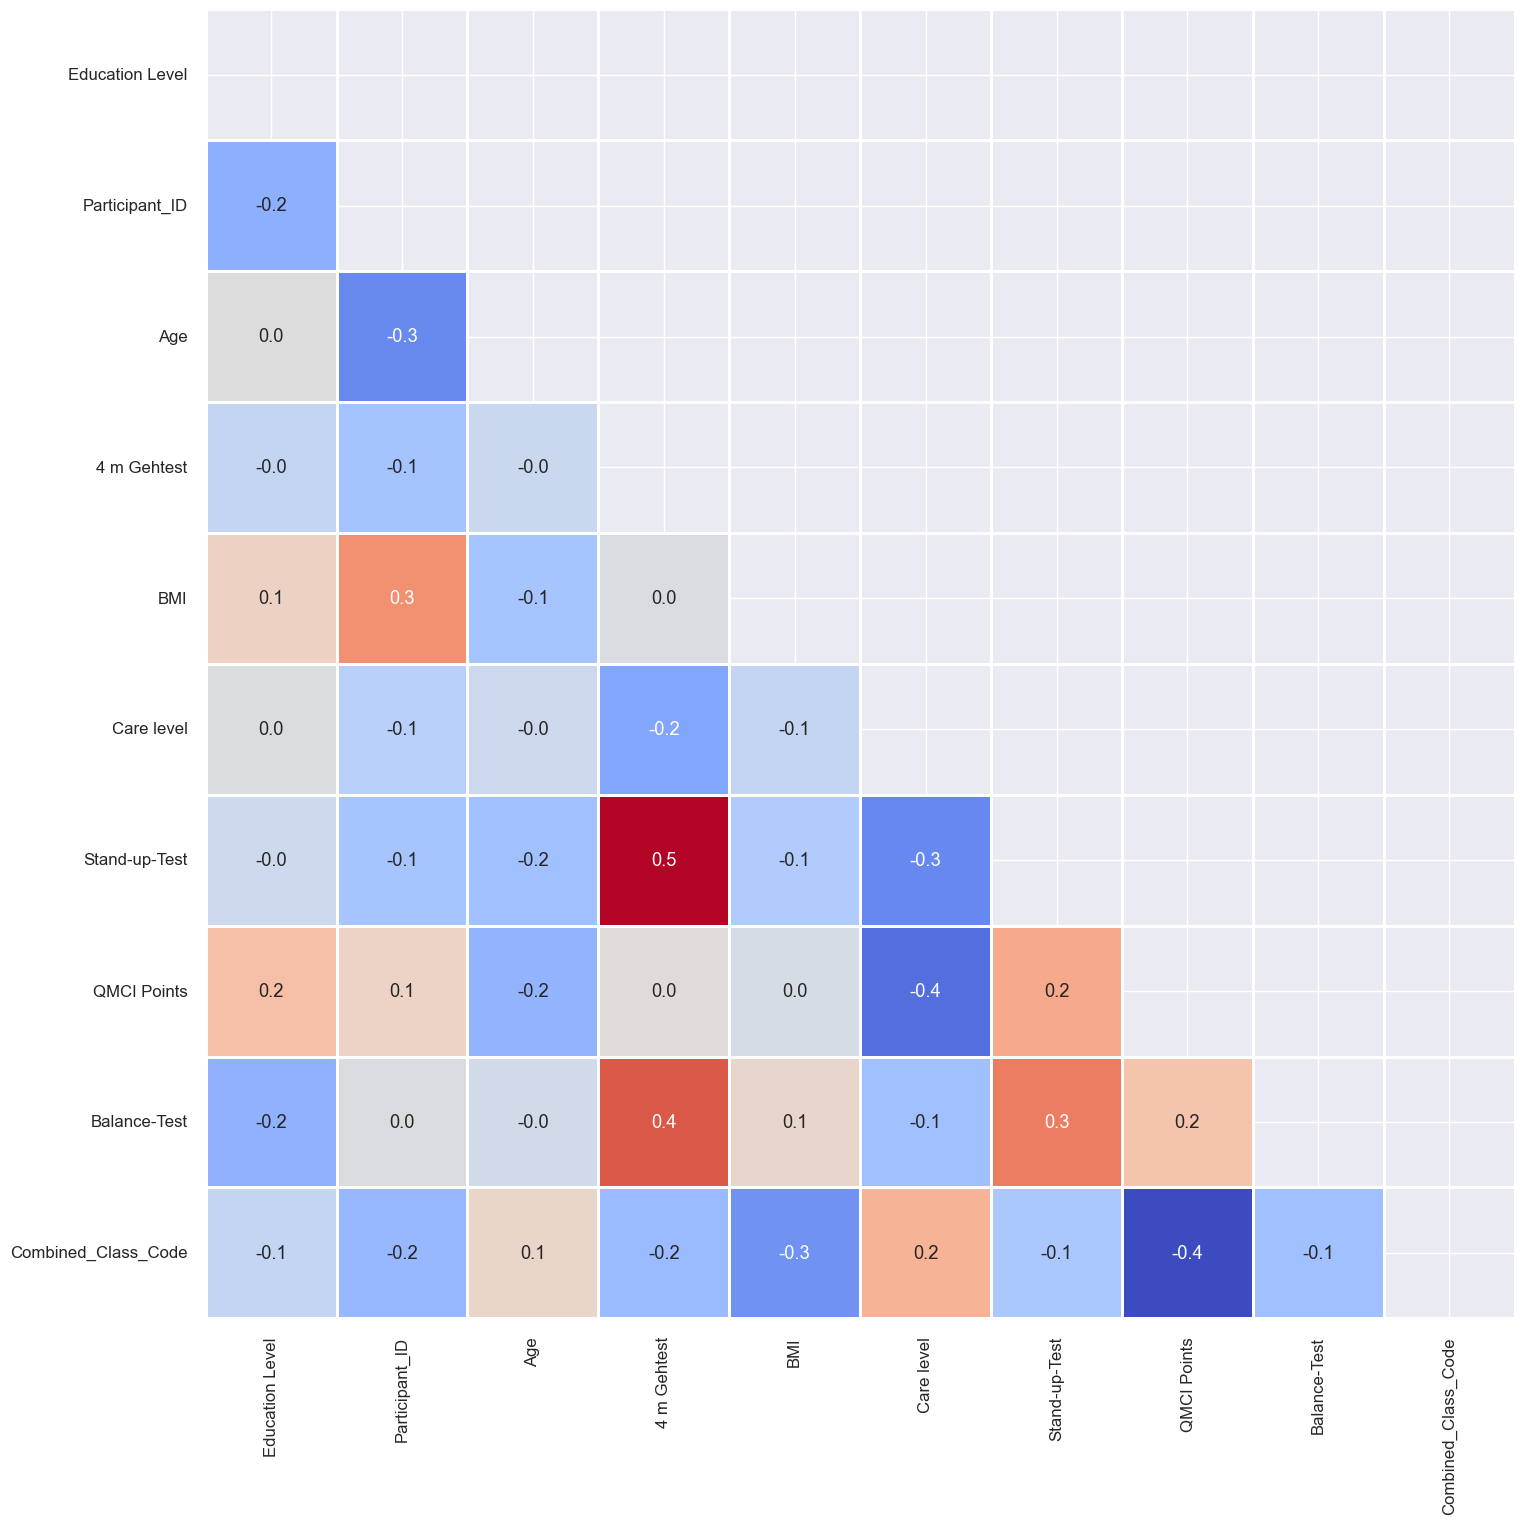

In [30]:
# Display correlations between numerical features
sns.set(font_scale=1.1)
correlation_train = train_df[continuous_features+["Combined_Class_Code"]].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

## Evaluation of Imputation and Scaling Method

Masked 1530 values
RMSE: 0.0918


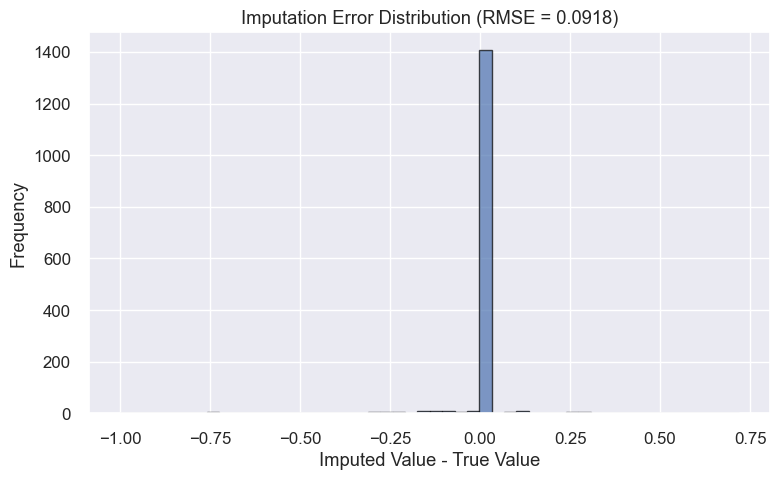

Masked 1530 values
RMSE: 0.0762


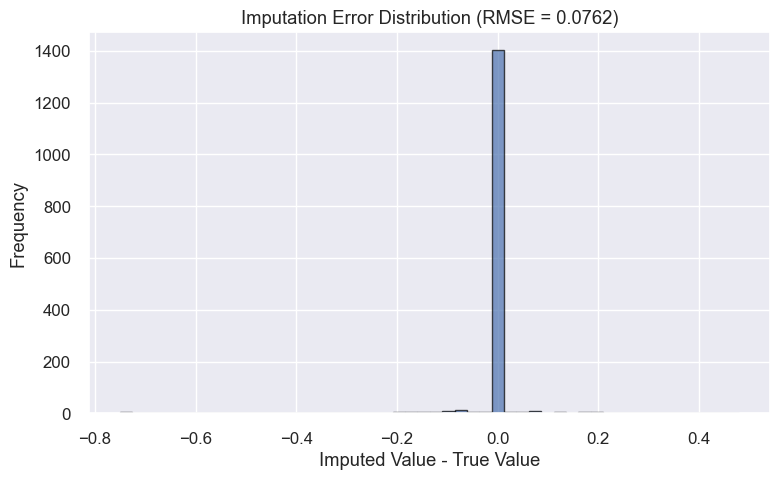

Masked 1530 values
RMSE: 0.0504


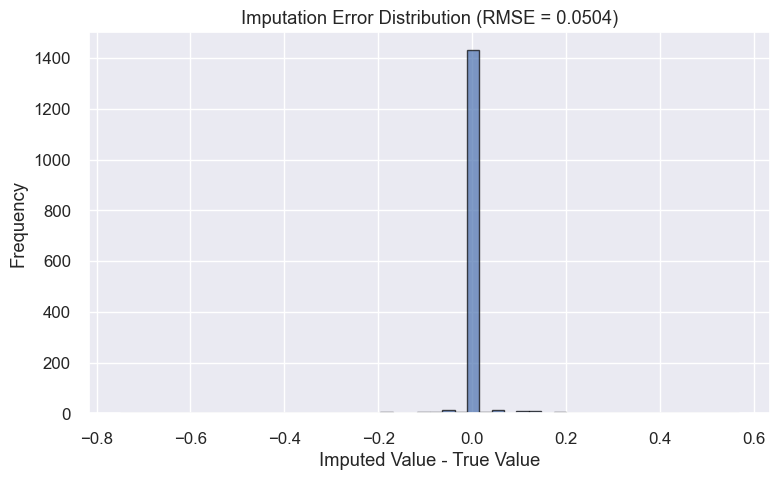

Masked 1530 values
RMSE: 0.0493


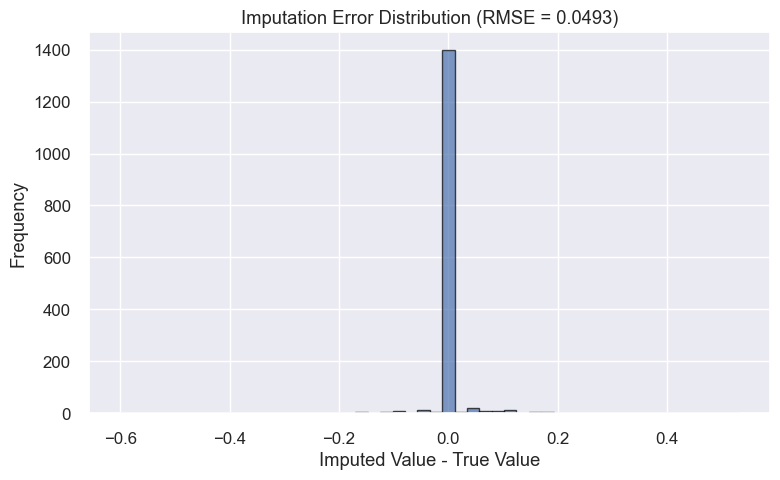

Masked 1530 values
RMSE: 0.0511


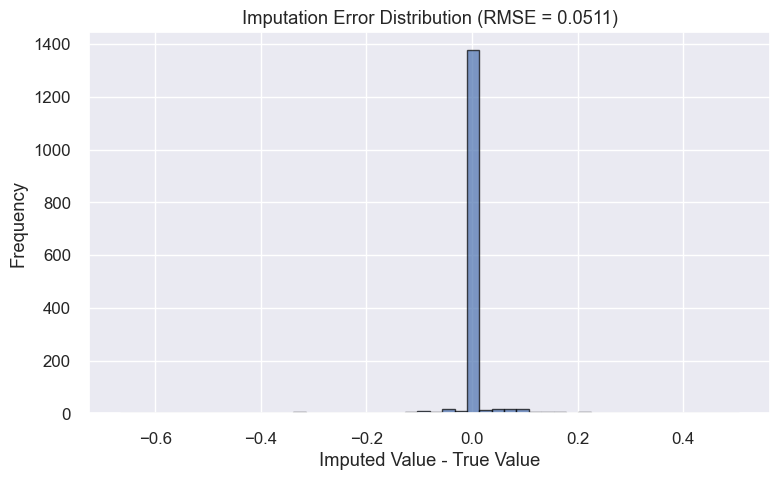

Masked 1530 values
RMSE: 0.9890


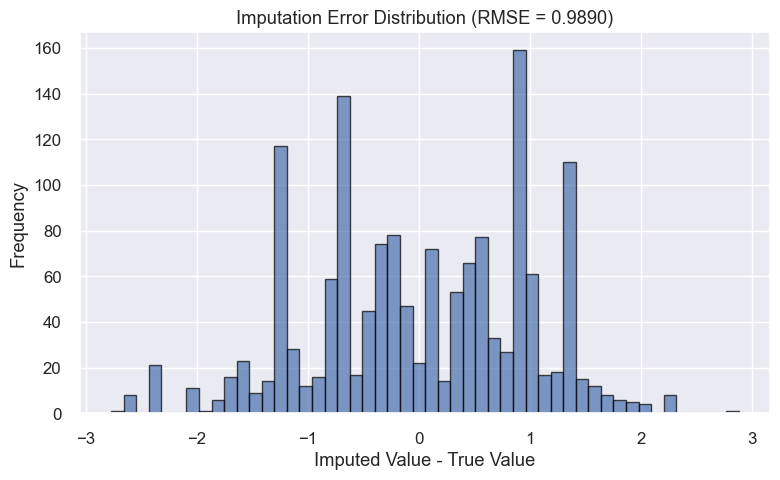

Masked 1530 values
RMSE: 0.1411


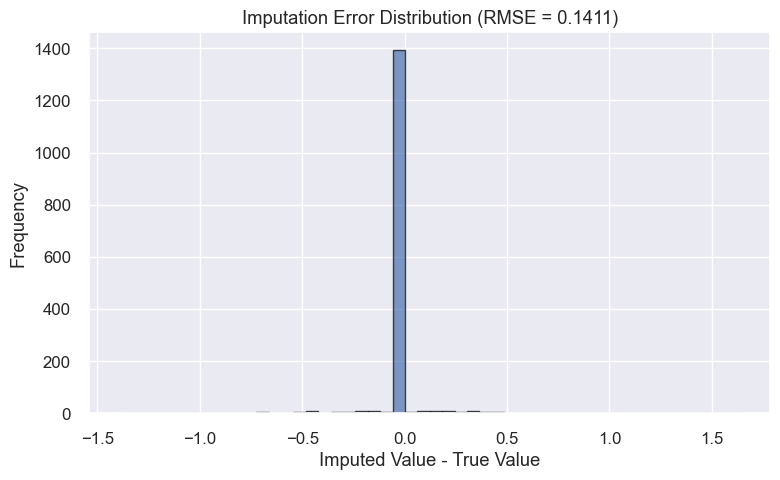

Masked 1530 values
RMSE: 0.7342


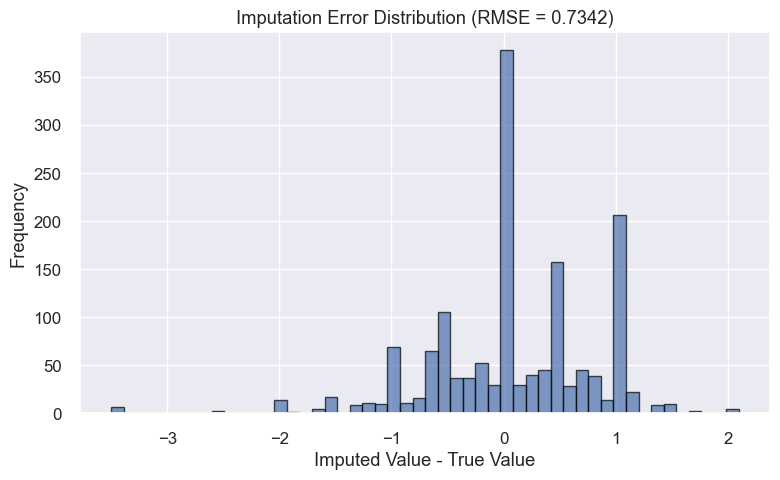

Masked 1530 values
RMSE: 0.1769


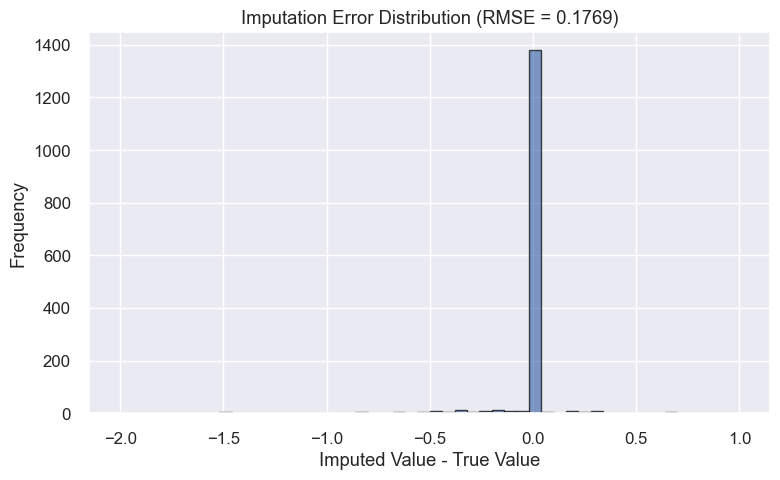

np.float64(0.17693683274024244)

In [31]:
def evaluate_imputer_with_plot(df, imputer, scaler, mask_fraction=0.1, random_state=random_state, plot=True, verbose=True):
    df = df.select_dtypes(include=[np.number])  
    np.random.seed(random_state)
    scaled_full = scaler.fit_transform(df)
    original_not_nan = ~np.isnan(scaled_full)
    random_mask = np.random.rand(*scaled_full.shape) < mask_fraction
    mask = random_mask & original_not_nan

    observed = scaled_full.copy()
    ground_truth = scaled_full.copy()
    observed[mask] = np.nan

    imputed = imputer.fit_transform(observed)

    errors = imputed[mask] - ground_truth[mask]
    rmse = np.sqrt(mean_squared_error(ground_truth[mask], imputed[mask]))

    if verbose:
        print(f"Masked {mask.sum()} values")
        print(f"RMSE: {rmse:.4f}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
        plt.title(f"Imputation Error Distribution (RMSE = {rmse:.4f})")
        plt.xlabel("Imputed Value - True Value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return rmse
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=2), MinMaxScaler())
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=3), MinMaxScaler())
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=4), MinMaxScaler()) 
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=5), MinMaxScaler()) 
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=6), MinMaxScaler())   
evaluate_imputer_with_plot(train_df, SimpleImputer(strategy='mean'), StandardScaler())  
evaluate_imputer_with_plot(train_df, KNNImputer(), StandardScaler())  
evaluate_imputer_with_plot(train_df, SimpleImputer(strategy='median'), RobustScaler())
evaluate_imputer_with_plot(train_df, KNNImputer(n_neighbors=3), RobustScaler())  


In [32]:
train_df.head()

,Participant_ID,Game,Sex,Age,Previous experience,Education Level,BMI,Care level,QMCI Points,4 m Gehtest,Stand-up-Test,Mobility Aids,Balance-Test,Combined_Class_Code
0,0,Rocket,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
1,0,Simple,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
2,0,Divided,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110
3,0,Birds,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,111
4,0,Habitats,w,89.0,No,9.0,18.0,6.0,13.5,2,1,1,2.0,110


# Model Evaluation

In [33]:
#seperate target
y = train_df["Combined_Class_Code"]
train_df = train_df.drop(["Combined_Class_Code"], axis=1)

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
for train_idx, test_idx in sgkf.split(train_df, y, groups=train_df["Participant_ID"]):
    X_train = train_df.iloc[train_idx]
    X_test = train_df.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    break  # use only the first split


In [35]:
# Identify columns
continuous_features = X_train.select_dtypes(include=['number']).drop(columns="Participant_ID", errors="ignore").columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Numerical pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

#Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine both in a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, continuous_features),
    ('cat', categorical_pipeline, categorical_features)
])


In [36]:
overlap = set(X_train["Participant_ID"]) & set(X_test["Participant_ID"])
print("Overlap:", len(overlap))

Overlap: 0


Here you can see that all rows for each participant are either in the train or test part (prevents data leakage) 


Running Optuna optimization for: LGBM
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 1.3109
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[206]	valid_0's multi_logloss: 1.18476
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[206]	valid_0's multi_logloss: 1.20127
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[206]	valid_0's multi_logloss: 1.25862
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's multi_logloss: 1.28026
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's multi_logloss: 1.19349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[269]

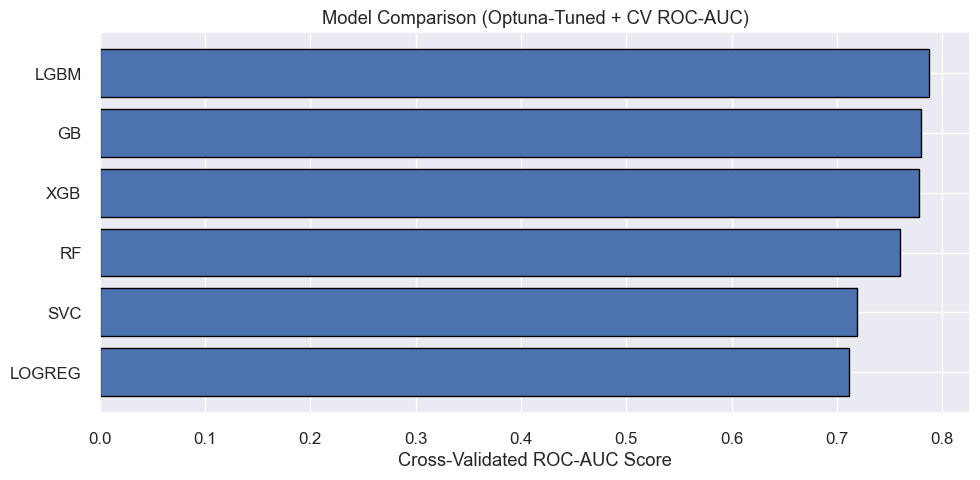

In [ ]:
# Preprocessing Setup
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
groups = X_train["Participant_ID"]

# Identify features
numerical_cols = X_train.select_dtypes(include=['number']).drop(columns="Participant_ID").columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Objective Function
def objective(trial, model_type="lgbm"):
    n_estimators = trial.suggest_int("n_estimators", 30, 500)
    max_depth = trial.suggest_int("max_depth", 2, 12)

    if model_type == "xgb":
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            colsample_bytree=colsample_bytree,
            use_label_encoder=False,
            eval_metric="mlogloss",
            random_state=random_state
        )

    elif model_type == "lgbm":
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 20)
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        max_bin = trial.suggest_int("max_bin", 100, 350, step=10)
        feature_fraction = trial.suggest_float("feature_fraction", 0.1, 1.0)
        model = LGBMClassifier(
            verbosity=-1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_data_in_leaf=min_data_in_leaf,
            subsample=subsample,
            max_bin=max_bin,
            feature_fraction=feature_fraction,
            random_state=random_state
        )

    elif model_type == "rf":
        max_features = trial.suggest_float("max_features", 0.1, 1.0)
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=random_state
        )

    elif model_type == "gb":
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
        subsample = trial.suggest_float("subsample", 0.1, 1.0)
        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=random_state
        )

    elif model_type == "svc":
        C = trial.suggest_float("C", 0.01, 10.0, log=True)
        model = SVC(C=C, kernel="rbf", probability=True, random_state=random_state)

    elif model_type == "logreg":
        C = trial.suggest_float("C", 0.01, 10.0, log=True)
        model = LogisticRegression(C=C, max_iter=1000, solver="lbfgs", multi_class="ovr", random_state=random_state)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
    oof_preds, oof_targets, oof_probas = [], [], []

    for train_idx, val_idx in sgkf.split(X_train, y_train_encoded, groups=groups):
        X_tr = X_train.iloc[train_idx].drop(columns=["Participant_ID"])
        X_val = X_train.iloc[val_idx].drop(columns=["Participant_ID"])
        y_tr = y_train_encoded[train_idx]
        y_val = y_train_encoded[val_idx]

        X_tr_proc = preprocessor.fit_transform(X_tr)
        X_val_proc = preprocessor.transform(X_val)


        if model_type == "lgbm":
            model.fit(
                X_tr_proc, y_tr,
                eval_set=[(X_val_proc, y_val)],
                eval_metric="multi_logloss",
                callbacks=[early_stopping(50)],
            )
        else:
            model.fit(X_tr_proc, y_tr)

        y_pred = model.predict(X_val_proc)
        y_proba = model.predict_proba(X_val_proc)

        oof_preds.extend(y_pred)
        oof_probas.extend(y_proba)
        oof_targets.extend(y_val)

    cv_auc = roc_auc_score(oof_targets, oof_probas, multi_class='ovr')
    return cv_auc

# Model Optimization
models_to_compare = ["lgbm", "xgb", "rf", "gb", "svc", "logreg"]
results = {}

for model_type in models_to_compare:
    print(f"\nRunning Optuna optimization for: {model_type.upper()}")
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=57))
    study.optimize(lambda trial: objective(trial, model_type), n_trials=50)

    print(f"Best AUC for {model_type.upper()}: {study.best_value:.4f}")
    print(f"Best Params for {model_type.upper()}: {study.best_params}")
    results[model_type] = {
        "CV ROC-AUC": study.best_value,
        "params": study.best_params
    }

# Leaderboard
leaderboard_df = pd.DataFrame([
    {"Model": model.upper(), "CV ROC-AUC": metrics["CV ROC-AUC"], **metrics}
    for model, metrics in results.items()
]).sort_values(by="CV ROC-AUC", ascending=False).reset_index(drop=True)

print("\nModel Leaderboard (Cross-Validated):")
print(leaderboard_df[["Model", "CV ROC-AUC"]])

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.barh(leaderboard_df["Model"], leaderboard_df["CV ROC-AUC"], edgecolor='black')
plt.xlabel("Cross-Validated ROC-AUC Score")
plt.title("Model Comparison (Optuna-Tuned + CV ROC-AUC)")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()



Evaluating LGBM with fixed Optuna parameters...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.980171
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 1.03042
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 1.05122
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 1.06521
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 1.05689

Evaluating XGB with fixed Optuna parameters...

Evaluating RF with fixed Optuna parameters...

Evaluating GB with fixed Optuna parameters...

Evaluating SVC with fixed Optuna parameters...

Evaluating LOGREG with fixed Optuna parameters...

 Optuna Models Leaderboard:
    M

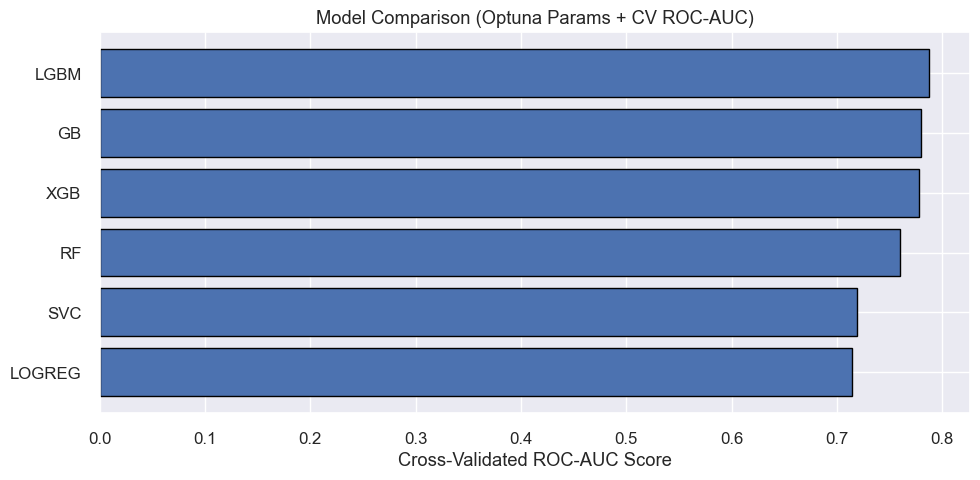

In [ ]:
# Extract only Optuna-tuned models
best_params_all_models = {
    model_name: result["params"]
    for model_name, result in results.items()
    if isinstance(result, dict) and "params" in result
}

# Model classes and valid params per model
model_classes = {
    "lgbm": LGBMClassifier,
    "xgb": XGBClassifier,
    "rf": RandomForestClassifier,
    "gb": GradientBoostingClassifier,
    "svc": SVC,
    "logreg": LogisticRegression
}

model_param_filters = {
    "lgbm": {"n_estimators", "max_depth", "learning_rate", "min_data_in_leaf", "subsample", "max_bin", "feature_fraction"},
    "xgb": {"n_estimators", "max_depth", "learning_rate", "colsample_bytree"},
    "rf": {"n_estimators", "max_depth", "max_features"},
    "gb": {"n_estimators", "max_depth", "learning_rate", "subsample"},
    "svc": {"C"},
    "logreg": {"C"},
}

# Evaluation Loop for Fixed Models
fixed_results = {}
for model_name, params in best_params_all_models.items():
    print(f"\nEvaluating {model_name.upper()} with fixed Optuna parameters...")

    ModelClass = model_classes[model_name]
    allowed_keys = model_param_filters[model_name]
    filtered_params = {k: v for k, v in params.items() if k in allowed_keys}

    if model_name == "svc":
        filtered_params["probability"] = True

    model = ModelClass(**filtered_params, random_state=random_state)

    val_aucs, train_aucs = [], []
    oof_preds, oof_targets, oof_probas = [], [], []
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

    for train_idx, val_idx in sgkf.split(X_train, y_train_encoded, groups=groups):
        X_tr = X_train.iloc[train_idx].drop(columns=["Participant_ID"])
        X_val = X_train.iloc[val_idx].drop(columns=["Participant_ID"])
        y_tr = y_train_encoded[train_idx]
        y_val = y_train_encoded[val_idx]

        X_tr_proc = preprocessor.fit_transform(X_tr)
        X_val_proc = preprocessor.transform(X_val)
        

        if model_name == "lgbm":
            model.fit(
                X_tr_proc, y_tr,
                eval_set=[(X_val_proc, y_val)],
                eval_metric="multi_logloss",
                callbacks=[early_stopping(50)],
            )
        elif model_name == "xgb":
            model.set_params(use_label_encoder=False, eval_metric="mlogloss")
            model.fit(X_tr_proc, y_tr)
        else:
            model.fit(X_tr_proc, y_tr)

        y_pred = model.predict(X_val_proc)
        y_proba = model.predict_proba(X_val_proc)
        y_proba_train = model.predict_proba(X_tr_proc)

        oof_preds.extend(y_pred)
        oof_probas.extend(y_proba)
        oof_targets.extend(y_val)

        val_auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
        train_auc = roc_auc_score(y_tr, y_proba_train, multi_class='ovr')
        val_aucs.append(val_auc)
        train_aucs.append(train_auc)

    fixed_results[model_name ] = {
        "CV ROC-AUC": round(roc_auc_score(oof_targets, oof_probas, multi_class='ovr'), 4),
        "CV Accuracy": round(accuracy_score(oof_targets, oof_preds), 4),
        "CV Precision": round(precision_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "CV Recall": round(recall_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "CV F1": round(f1_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
    }

# Fixed Models Leaderboard
fixed_leaderboard_df = pd.DataFrame([
    {"Model": model.upper(), **metrics}
    for model, metrics in fixed_results.items()
]).sort_values(by="CV ROC-AUC", ascending=False).reset_index(drop=True)

print("\n Optuna Models Leaderboard:")
print(fixed_leaderboard_df)


LightGBM outperformed the other models, followed closely by Gradient Boosting and XGBoost. 

# Best Model Evaluation

Here the entire process is re-implemented, just for LightGBM, in order to further refine it. 

In [ ]:
# Preprocessing setup
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
groups = X_train["Participant_ID"]

continuous_features = X_train.select_dtypes(include=['number']).drop(columns="Participant_ID", errors="ignore").columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, continuous_features),
    ('cat', categorical_pipeline, categorical_features)
])


def lgbm_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_bin": trial.suggest_int("max_bin", 100, 350, step=10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "verbosity": -1,
        "random_state": random_state
    }

    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
    oof_probas, oof_targets = [], []

    for train_idx, val_idx in sgkf.split(X_train, y_train_encoded, groups=groups):
        X_tr = X_train.iloc[train_idx].drop(columns="Participant_ID")
        X_val = X_train.iloc[val_idx].drop(columns="Participant_ID")
        y_tr = y_train_encoded[train_idx]
        y_val = y_train_encoded[val_idx]

        X_tr_proc = preprocessor.fit_transform(X_tr)
        X_val_proc = preprocessor.transform(X_val)

        model = LGBMClassifier(**params)
        model.fit(X_tr_proc, y_tr, eval_set=[(X_val_proc, y_val)])

        y_proba = model.predict_proba(X_val_proc)
        oof_probas.extend(y_proba)
        oof_targets.extend(y_val)

    return roc_auc_score(oof_targets, oof_probas, multi_class='ovr')

print("\nRunning Optuna for LGBM...")
lgbm_study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=57))
lgbm_study.optimize(lgbm_objective, n_trials=50)

best_params = lgbm_study.best_params
print("\nBest ROC-AUC:", round(lgbm_study.best_value, 4))
print("Best Hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Evaluate LGBM

lgbm_model = LGBMClassifier(**best_params,
                          objective="multiclass",
                          eval_metric="multi_logloss",
                          num_class=len(label_encoder.classes_),
                          random_state=random_state)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
oof_preds, oof_probas, oof_targets = [], [], []

for train_idx, val_idx in sgkf.split(X_train, y_train_encoded, groups=groups):
    X_tr = X_train.iloc[train_idx].drop(columns="Participant_ID")
    X_val = X_train.iloc[val_idx].drop(columns="Participant_ID")
    y_tr = y_train_encoded[train_idx]
    y_val = y_train_encoded[val_idx]

    X_tr_proc = preprocessor.fit_transform(X_tr)
    X_val_proc = preprocessor.transform(X_val)

    lgbm_model.fit(X_tr_proc, y_tr)

    y_pred = lgbm_model.predict(X_val_proc)
    y_proba = lgbm_model.predict_proba(X_val_proc)

    oof_preds.extend(y_pred)
    oof_probas.extend(y_proba)
    oof_targets.extend(y_val)

# Metrics + Leaderboard

lgbm_result = {
    "Model": "LGBM",
    "CV ROC-AUC": round(roc_auc_score(oof_targets, oof_probas, multi_class='ovr'), 4),
    "CV Accuracy": round(accuracy_score(oof_targets, oof_preds), 4),
    "CV Precision": round(precision_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
    "CV Recall": round(recall_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
    "CV F1": round(f1_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
}

lgbm_leaderbord = pd.DataFrame([lgbm_result])

print("\nLGBM:")
print(lgbm_leaderbord)



Running Optuna for LGBM...

Best ROC-AUC: 0.7918
Best Hyperparameters:
  n_estimators: 234
  max_depth: 4
  learning_rate: 0.06782983816372003
  min_data_in_leaf: 33
  subsample: 0.6546872085145422
  max_bin: 330
  feature_fraction: 0.5035728256977485

LGBM:
  Model  CV ROC-AUC  CV Accuracy  CV Precision  CV Recall   CV F1
0  LGBM      0.7918       0.5701        0.5589     0.5701  0.5629


## To save the model, preprocessor and label encoder

In [38]:
# Final training using best params
final_model = LGBMClassifier(**best_params)
X_train_clean = X_train.drop(columns=["Participant_ID"])
X_train_proc = preprocessor.fit_transform(X_train_clean)


final_model.fit(X_train_proc, y_train_encoded)

# Save model + preprocessor + label encoder
import joblib
joblib.dump(final_model, "lgbm.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

# Evaluation metrics

In [39]:
X_train = X_train.drop(columns=["Participant_ID"], errors="ignore")
X_test = X_test.drop(columns=["Participant_ID"], errors="ignore")

In [ ]:
# Get best params from Optuna
best_params = lgbm_study.best_params
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Use this for training
y_test_encoded = label_encoder.transform(y_test)

# Re-initialize model
lgbm_classifier = LGBMClassifier(**best_params, random_state=random_state, verbose=-1)

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ("lgbm", lgbm_classifier)
])

# Fit the model
lgbm_pipeline.fit(X_train, y_train_encoded)

# Predict on test set
y_test_proba = lgbm_pipeline.predict_proba(X_test)
y_test_pred = lgbm_pipeline.predict(X_test)


# Evaluate
test_auc = roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr')

Final ROC-AUC on test set: 0.7766144344503652


In [ ]:
# Combine predictions and true labels with Game info for analysis
test_results = X_test.copy()
test_results['y_true'] = y_test
test_results['Game'] = X_test['Game']  
test_results['y_pred_proba'] = list(y_test_proba) 

# Convert to DataFrame format with class probabilities as separate columns
proba_df = pd.DataFrame(y_test_proba, columns=[f'class_{i}' for i in range(y_test_proba.shape[1])])
test_results = test_results.reset_index(drop=True).join(proba_df)

# Group by Game and compute ROC-AUC per group
game_scores = []

for game, group in test_results.groupby('Game'):
    try:
        y_true = group['y_true']
        y_proba = group[[f'class_{i}' for i in range(y_test_proba.shape[1])]]
        score = roc_auc_score(y_true, y_proba, multi_class='ovr')
        game_scores.append({'Game': game, 'ROC_AUC': score})
    except ValueError:
        # Not enough classes present in this group to compute AUC
        game_scores.append({'Game': game, 'ROC_AUC': None})

# Convert to DataFrame for easy viewing
game_auc_df = pd.DataFrame(game_scores).sort_values(by='ROC_AUC', ascending=False)
game_auc_df


,Game,ROC_AUC
10,Ladybug,0.882215
8,Habitats,0.788636
7,Flexi,0.763095
19,Targets,0.747844
1,Birds,0.745945
2,Cloudy,0.735077
16,Simple,0.705486
5,Evolve,0.665331
0,Arrows,0.661064
3,Divided,0.657015


In [42]:
# Combine y_test and Game column
y_test_df = X_test[['Game']].copy()
y_test_df['y_true'] = y_test

# Group by Game and class, then count the samples
class_counts_per_game = y_test_df.groupby(['Game', 'y_true']).size().unstack(fill_value=0)
class_counts_per_game

y_true,001,011,110,111
Game,,,,
Arrows,1,1,6,4
Birds,8,4,1,6
Cloudy,1,4,2,8
Divided,1,2,7,4
Drops,0,1,8,2
Evolve,2,3,4,8
Flaneur,13,3,0,3
Flexi,6,2,6,2
Habitats,3,2,7,1


As you can see there are outcome labels with 0 in the test. That's why there were some NA when evaluating each game seperately

In [ ]:
# Combine predictions and true labels with Game info for analysis
test_results = X_test.copy()
test_results['y_true'] = y_test
test_results['Game'] = X_test['Game']  # Ensure Game column is present
test_results['y_pred_proba'] = list(y_test_proba)  # Optional, not strictly needed here

# Convert class probabilities into separate columns
proba_df = pd.DataFrame(y_test_proba, columns=[f'class_{i}' for i in range(y_test_proba.shape[1])])
test_results = test_results.reset_index(drop=True).join(proba_df)

# Compute ROC-AUC per Game
game_scores = []

for game, group in test_results.groupby('Game'):
    y_true = group['y_true']
    class_count = y_true.nunique()

    if class_count >= 2:
        y_proba = group[[f'class_{i}' for i in range(y_test_proba.shape[1])]]
        try:
            score = roc_auc_score(y_true, y_proba, multi_class='ovr')
        except ValueError:
            score = None 
    else:
        score = None  # Only one class present

    game_scores.append({
        'Game': game,
        'ROC_AUC': score,
        'Class_Count': class_count
    })

# Convert to DataFrame for analysis
game_auc_df = pd.DataFrame(game_scores).sort_values(by='ROC_AUC', ascending=False)
game_auc_df

,Game,ROC_AUC,Class_Count
10,Ladybug,0.882215,4
8,Habitats,0.788636,4
7,Flexi,0.763095,4
19,Targets,0.747844,4
1,Birds,0.745945,4
2,Cloudy,0.735077,4
16,Simple,0.705486,4
5,Evolve,0.665331,4
0,Arrows,0.661064,4
3,Divided,0.657015,4


In [ ]:
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Get predicted class labels
y_test_pred = lgbm_pipeline.predict(X_test)

# Combine predictions, true labels, and Game info
test_results = X_test.copy()
test_results['y_true'] = y_test_encoded
test_results['y_pred'] = y_test_pred
test_results['Game'] = X_test['Game']  

# Group by Game and compute accuracy per group
game_scores = []

for game, group in test_results.groupby('Game'):
    y_true = group['y_true']
    y_pred = group['y_pred']
    score = accuracy_score(y_true, y_pred)
    game_scores.append({'Game': game, 'Accuracy': score})

# Convert to DataFrame for viewing
game_accuracy_df = pd.DataFrame(game_scores).sort_values(by='Accuracy', ascending=False)
game_accuracy_df

,Game,Accuracy
9,Hexagon,0.833333
15,Simon,0.750000
4,Drops,0.727273
12,React,0.714286
18,Snake,0.692308
7,Flexi,0.687500
13,Rocket,0.650000
6,Flaneur,0.631579
17,Ski,0.588235
2,Cloudy,0.533333


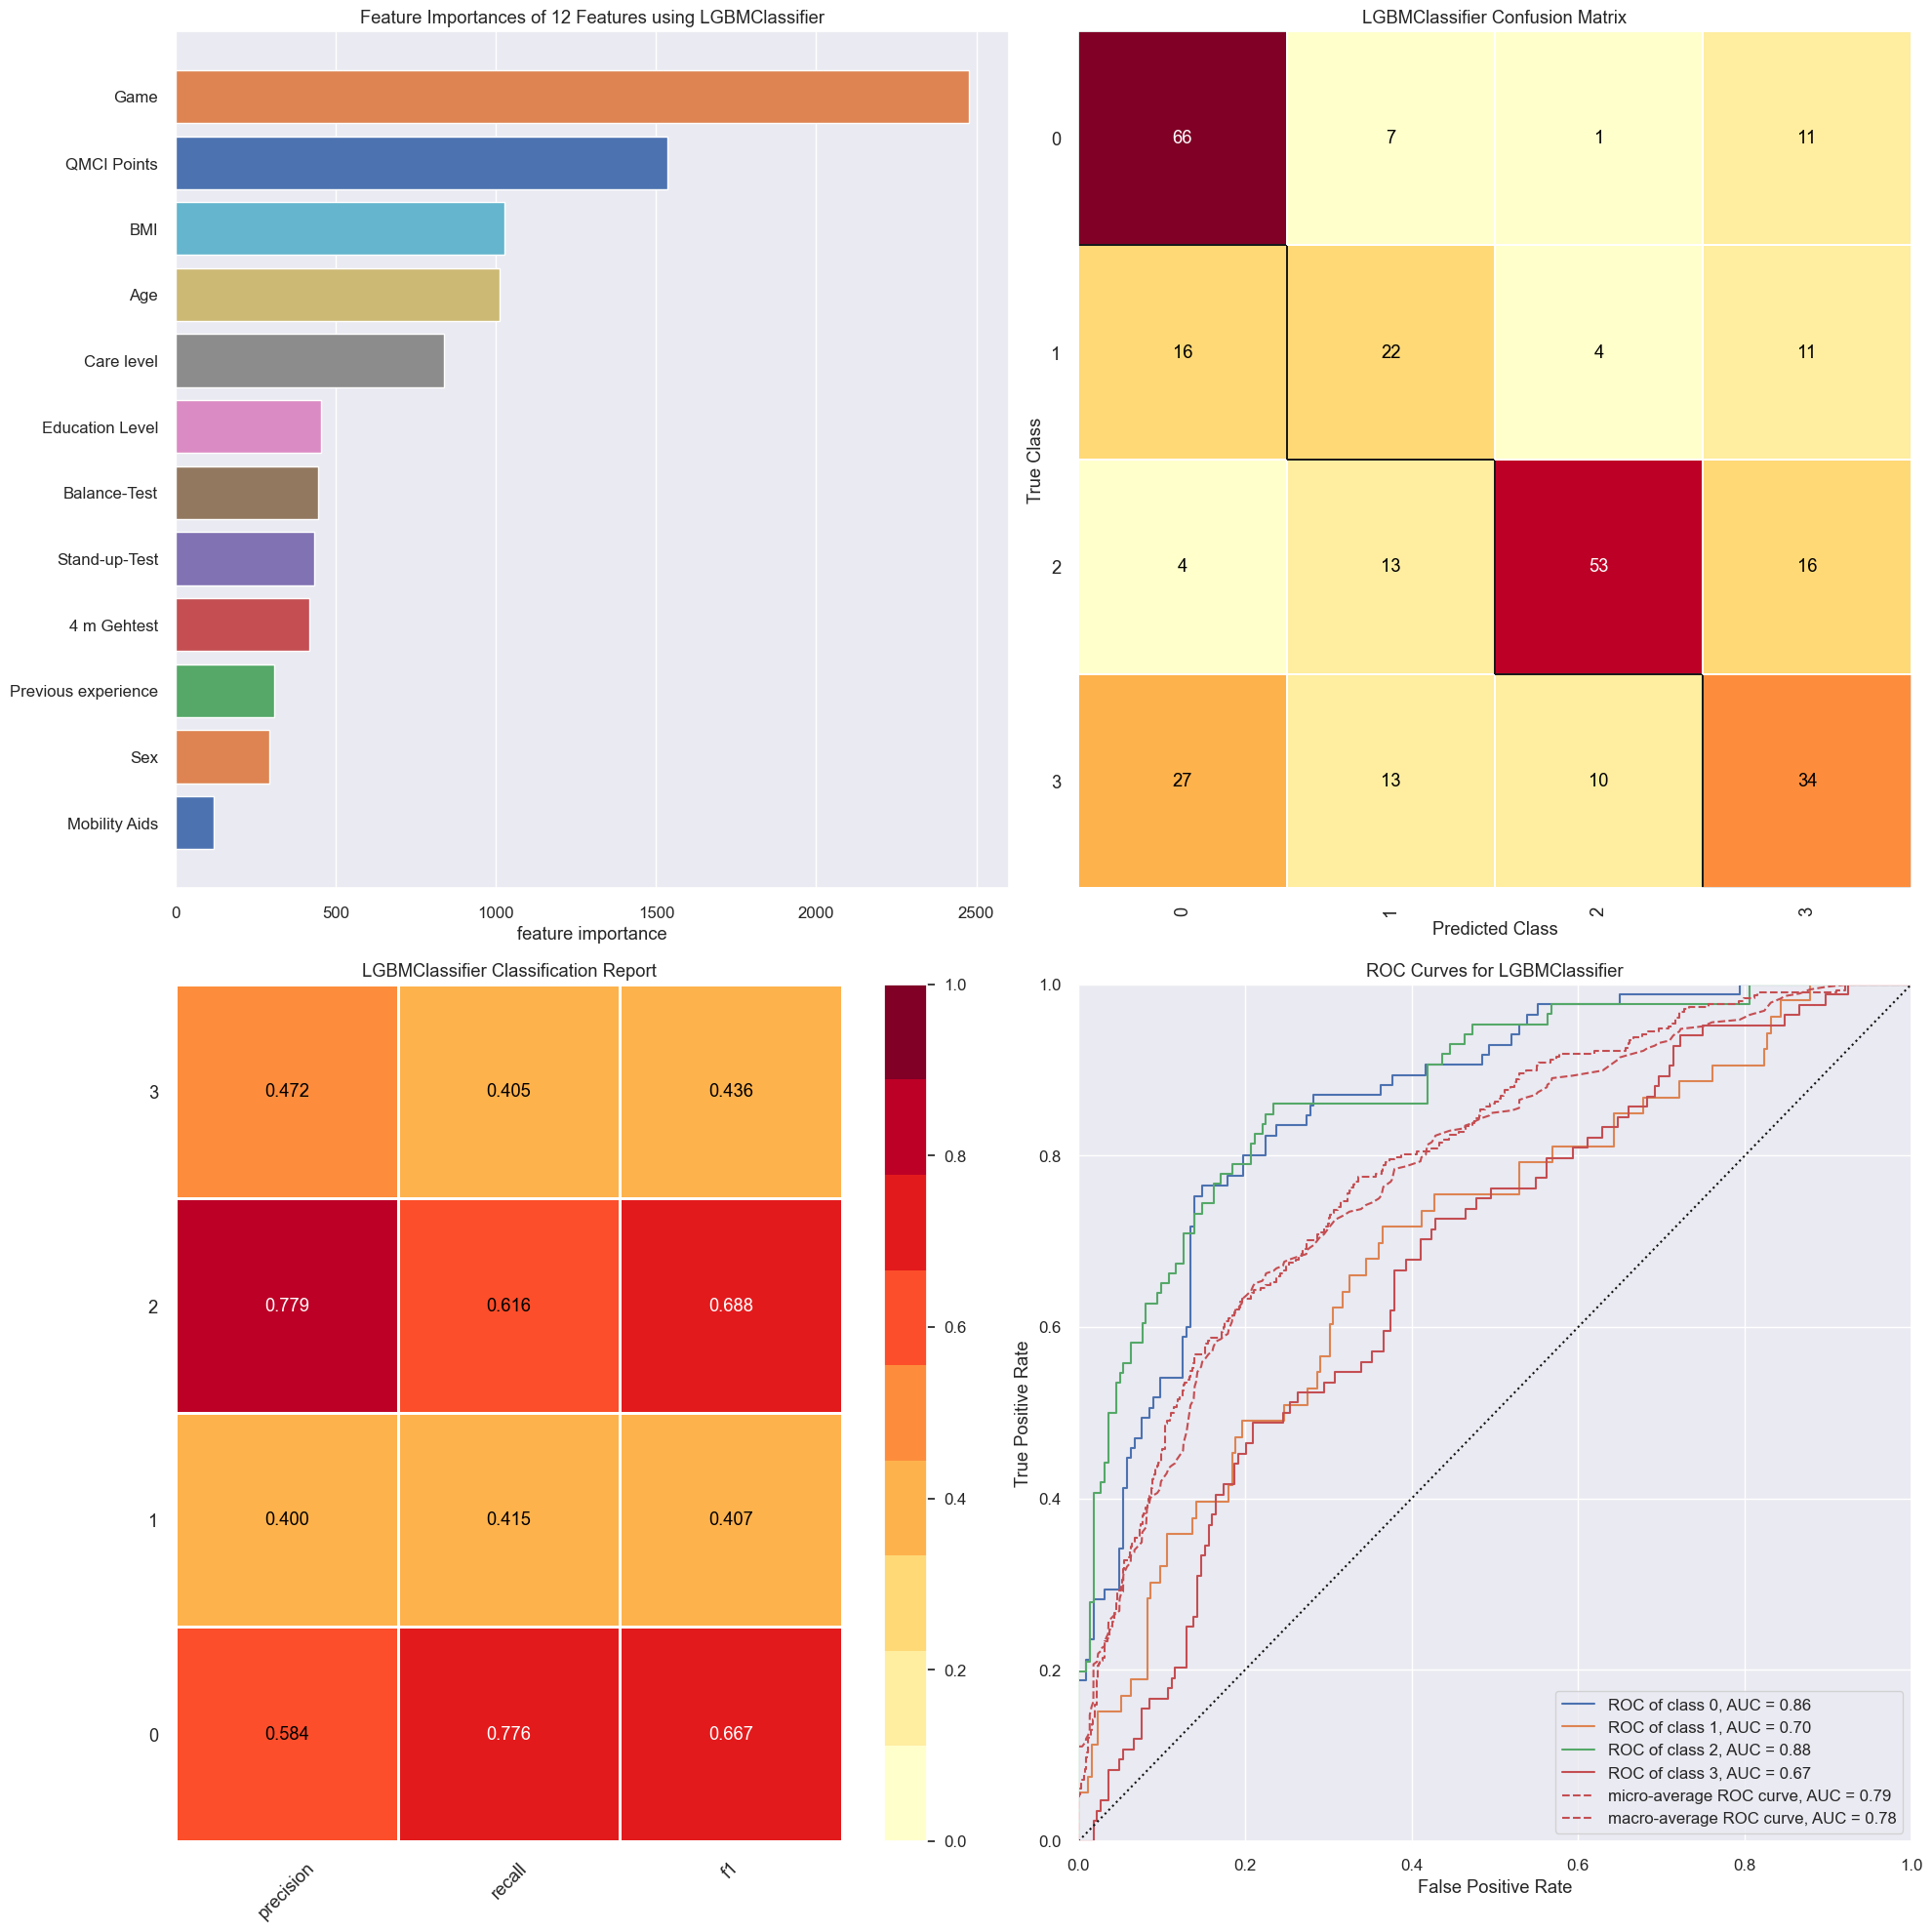

In [45]:
# Encode target
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit pipeline
lgbm_pipeline.fit(X_train, y_train_encoded)

# Preprocess data for FeatureImportances
X_train_transformed = lgbm_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = lgbm_pipeline.named_steps['preprocessor'].transform(X_test)

# Get full feature names
ohe = lgbm_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([continuous_features, ohe_feature_names])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Visualizers
visualgrid = [
    FeatureImportances(
        lgbm_pipeline.named_steps['lgbm'],
        ax=axes[0][0],
        labels=all_feature_names,
        relative=False,     # Prevents type error on int feature_importances_
        stack=False
    ),
    ConfusionMatrix(lgbm_pipeline, ax=axes[0][1]),
    ClassificationReport(lgbm_pipeline, ax=axes[1][0]),
    ROCAUC(lgbm_pipeline, ax=axes[1][1]),
]

# Fit and score visualizers
visualgrid[0].fit(X_train_transformed, y_train_encoded)
visualgrid[0].score(X_test_transformed, y_test_encoded)
visualgrid[0].finalize()

for viz in visualgrid[1:]:
    viz.fit(X_train, y_train_encoded)
    viz.score(X_test, y_test_encoded)
    viz.finalize()

plt.show()


## SHAP Evaluation

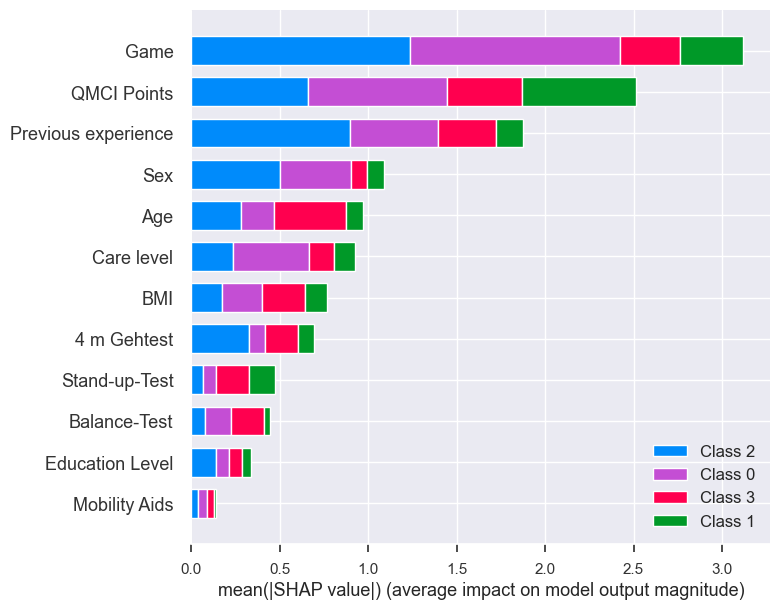

In [46]:
model = lgbm_pipeline.named_steps['lgbm']

explainer = shap.TreeExplainer(model, feature_perturbation='interventional')

# Use transformed data for SHAP
shap_values = explainer.shap_values(X_test_transformed, check_additivity=False)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Plot
shap.summary_plot(shap_values, X_test_transformed_df, max_display=X_test_transformed_df.shape[1], plot_type="bar")

In [48]:
print(label_encoder.classes_)


['001' '011' '110' '111']


In [ ]:
# Build dictionary with CV and Test results stacked vertically
lgbm_results_stacked = {
    "LGBM CV": {
        "ROC-AUC": round(roc_auc_score(oof_targets, oof_probas, multi_class='ovr'), 4),
        "Accuracy": round(accuracy_score(oof_targets, oof_preds), 4),
        "Precision": round(precision_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "Recall": round(recall_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
        "F1": round(f1_score(oof_targets, oof_preds, average="weighted", zero_division=0), 4),
    },
    "LGBM Test": {
        "ROC-AUC": round(roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr'), 4),
        "Accuracy": round(accuracy_score(y_test_encoded, y_test_pred), 4),
        "Precision": round(precision_score(y_test_encoded, y_test_pred, average="weighted", zero_division=0), 4),
        "Recall": round(recall_score(y_test_encoded, y_test_pred, average="weighted", zero_division=0), 4),
        "F1": round(f1_score(y_test_encoded, y_test_pred, average="weighted", zero_division=0), 4),
    }
}

# Create DataFrame
lgbm_leaderboard_df = pd.DataFrame.from_dict(lgbm_results_stacked, orient='index')
print("\nLGBM Leaderboard (CV vs Test):")
print(lgbm_leaderboard_df)



LGBM Leaderboard (CV vs Test):
           ROC-AUC  Accuracy  Precision  Recall      F1
LGBM CV     0.7918    0.5701     0.5589  0.5701  0.5629
LGBM Test   0.7766    0.5682     0.5764  0.5682  0.5652
